# Calculation of gravitational wave sensitivity

Attempts to understand how important radio wave effects and accelerations are

Note that some calculations are in CGS and others in SI

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#cgs constants
estat = 4.8032e-10 #Statcoulomb
mp = 1.6726e-24 #g
me = 9.11e-28 #g
lightspeed = 2.9979e10 #cm/s
lightspeed_SI = 2.9979e8 #cm/s
AU_in_cm=1.496e13 #cm


#SI units
mp_kg = mp*1e-3 #kg
AU_in_meter = AU_in_cm*1e-2 #m

# conversions
nanoTeslatoGauss = 1e-5
statvolttoV = 299.79 #statvolt to volt
mcubetocmcube = 1e6
secinday = 3600 * 24
secinyear = 3.15e7
watttoerg = 1e7

In [2]:
# spacecraft specs


nuGHz = 30 #GHz -- radio frequency
radio_enhancement_beamnoise = 1.5 #increase in phase noise from taking out plasma (sqrt(2)=1.414 is the limit when wavelengths are most disparate)
lambda0 = lightspeed/(nuGHz*1e9)
print("radio wavelength = ", lambda0)
Rspacecraft_cm = 200 #cm  (doesn't actually matter for Voltage we quote, but does matter for acceleration)
mass_spacecraft_kg = 1000 #kg
vsat_kmsec = 20 #km/s  #motion relative to dust of spacecraft
area_spacecraft_irradiance_msq = 10 #m^2
area_spacecraft_dust_msq= area_spacecraft_irradiance_msq  #m^2
area_spacecraft_drag_msq = area_spacecraft_irradiance_msq #m^2
mass_spacecraft_g = 1000*mass_spacecraft_kg #kg 
cmpermeter = 0.01 #cm to meter

#baseline length array and number of baselines considered in plots (I've never tried this code with different value than two)
baseline_length_arr_AU = np.array([10, 30])
num_baselines = len(baseline_length_arr_AU)

#frequencies to consider for all calculations
freq_arr = np.logspace(-8, -2, 1000)

#regarding interplanetary medium
vsolar_wind_kmsec = 500 #km/s  
meanfluxsun_arr= 1361/baseline_length_arr_AU**2 #W/m^2
ne_solarwind_arr = 5*10**-2*(baseline_length_arr_AU/10)**-2 #cm^-3

#density of solar wind with Solar radius in cm^-3
def ne_solarwind(rAU):
    return 5*10**-2*(rAU/10)**-2  #cm^-3

radio wavelength =  0.9993


# Calculations of all acceleration sources

## Accelerations form Solar irradiance variations
Now we use that $m a = dE/dt/c =$ energy flux $\times$ Area/$c$

The RMS fluctuations from sun file are 2.91624516756702e-07%, although I think number should be half this. Might be because I'm using a bluish color filter


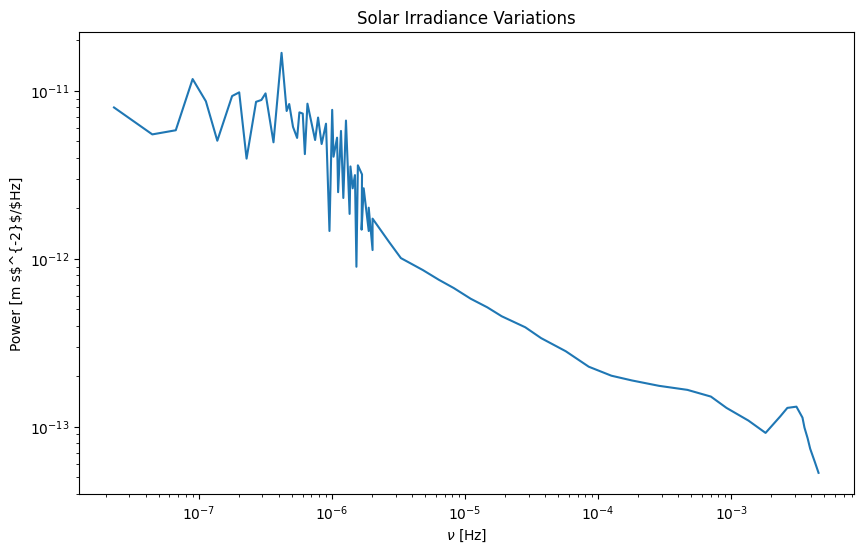

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad


# Read solar irradiance variation power data from file
solarirradiancevariationpower = np.genfromtxt('OSS_data_files/solarirradiancevariationstotal.txt')

# Extract frequency and power data
nu_solaracc = 10**solarirradiancevariationpower[:, 0]  # Convert log frequencies
solar_power_variation = 10**solarirradiancevariationpower[:, 1]  # Convert log power

# Initialize an array to store acceleration data for each baseline length
num_freqs = len(nu_solaracc)
acc_solar_irradiance_msm2Hzmp5_arr = np.zeros((num_baselines, num_freqs))

# Loop over each baseline length to compute the acceleration
for i in range(num_baselines):
    meanfluxsun = meanfluxsun_arr[i]
    
    # Compute acceleration due to solar irradiance variations
    acceleration_solar_irradiance_msm2Hzmp5 = (
        (solar_power_variation * 1e-6 * meanfluxsun**2)**0.5 *
        area_spacecraft_irradiance_msq / mass_spacecraft_kg / lightspeed_SI  #the 1e-6 converts from the ppm unit used in the file
    )  # Units: m/s^2/Hz^0.5
    
    # Store the acceleration data
    acc_solar_irradiance_msm2Hzmp5_arr[i, :] = acceleration_solar_irradiance_msm2Hzmp5

# Perform interpolation over freq_arr for each baseline length
acc_solar_irradiance_msm2Hzmp5_interpolated_arr = np.zeros((num_baselines, len(freq_arr)))

for i in range(num_baselines):
    acc_solar_irradiance_msm2Hzmp5_interpolated_arr[i, :] = np.interp(
        freq_arr, nu_solaracc, acc_solar_irradiance_msm2Hzmp5_arr[i, :]
    )


##############################################################################
#Plots the solar irradiance power
################################################################################
make_solar_plot = True
if make_solar_plot:
    plt.figure(figsize=(10, 6))
    plt.loglog(nu_solaracc, acc_solar_irradiance_msm2Hzmp5_arr[-1,:], label='Solar Irradiance Variations')
    plt.xlabel(r'$\nu$ [Hz]')
    plt.ylabel('Power [m s$^{-2}$/$Hz]')
    plt.title('Solar Irradiance Variations')

acc_solar_irradiance_msm2Hzmp5_arr  = acc_solar_irradiance_msm2Hzmp5_interpolated_arr

# Check if variance makes sense
#def power_cc_solar_irradiance_msm2Hz(nu, power_variation):
#    return 1e-12 * np.interp(nu, solarirradiancevariationpower[:, 0], power_variation**2)

# Check if variance makes sense
def power_cc_solar_irradiance_msm2Hz(nu):
    return 1e-12 * np.interp(nu, solarirradiancevariationpower[:, 0], solarirradiancevariationpower[:, 1]**2)

# Calculate variance
variance, _ = quad(power_cc_solar_irradiance_msm2Hz, 2e-8, 4e-3)
rms_fluctuation = 100 * np.sqrt(variance)
print(f"The RMS fluctuations from sun file are {rms_fluctuation}%, although I think number should be half this. Might be because I'm using a bluish color filter")



## Now let's calculate accelerations form dust collisions

In [4]:
from scipy.integrate import quad


#values used in boone and Mcquinn
#n0 = 2e-17*(baseline_length_AU/5)**-1.3 #cm^-3 
#m0 = 8e-7 #g

#using values motivaed by dust measurements in solar sytem
drhodustdlogm = 1.2e-27 #g/cm^3; is flat starting at 10^-12 g to 10^-9, without measurements above this
mmax_dust=1e-9; mmin_dust=1e-12; mmax_dust2 = 1e-7 #g (having a second max is for making two plots)
rhodust = drhodustdlogm*np.log(mmax_dust/mmin_dust) #since flat in log

mass_spacecraft_g=  mass_spacecraft_kg*1000
area_spacecraft_dust_cgs = area_spacecraft_dust_msq*1e4 #cm^2

#simple estimates
m0 = mmax_dust
n0 = rhodust/m0

#an intermediate print out to show dust accelerations
dv_mps = (vsat_kmsec*1e3)*m0/mass_spacecraft_g #m/s  (1e3 convets to meters from cm)
rate =  area_spacecraft_dust_cgs*n0*(vsat_kmsec*1e5) #s^-1
print("velocity change from collision in m/s=", dv_mps, " rate in days^-1=", rate*3600*24, " for m_dust=", m0)

def integrandAccelerationPowerDust_perlogM(logmdust):
    mdust= np.exp(logmdust)
    dv_mps = (vsat_kmsec*1e3)*mdust/mass_spacecraft_g #m/s
    rate =  area_spacecraft_dust_cgs*drhodustdlogm/mdust*(vsat_kmsec*1e5) #s^-1
    return 2*dv_mps**2*rate  #the two is because this is the one sided power



# Calculate the acceleration noise power
accelerationPower = quad(integrandAccelerationPowerDust_perlogM, np.log(mmin_dust), np.log(mmax_dust))[0]
acc_dust_msm2Hzmp5 =  np.sqrt(accelerationPower)*np.ones(len(freq_arr))  #I'm calling this acceleration since it's related to dx in same way

# Calculate the acceleration noise for a second max mass
accelerationPower_2 = quad(integrandAccelerationPowerDust_perlogM, np.log(mmin_dust), np.log(mmax_dust2))[0]
acc_dust_msm2Hzmp5_2 =  np.sqrt(accelerationPower_2)*np.ones(len(freq_arr))  #I'm calling this acceleration since it's related to dx in same way

print("dust acceleration power = ", np.sqrt(accelerationPower), np.sqrt(accelerationPower_2))


velocity change from collision in m/s= 2.0000000000000002e-11  rate in days^-1= 0.1432392134649736  for m_dust= 1e-09
dust acceleration power =  1.3849476524403376e-14 1.3856337178345495e-13


In [5]:
from scipy.integrate import quad

#using values motivaed by dust measurements in solar sytem
drhodustdlogm = 1.2e-27 #g/cm^3; is flat starting at 10^-12 g to 10^-9, without measurements above this
mmax_dust=1e-9; mmin_dust=1e-12; mmax_dust2 = 1e-7 #g (having a second max is for making two plots)
rhodust = drhodustdlogm*np.log(mmax_dust/mmin_dust) #assumes flat density distribution in log

mass_spacecraft_g=  mass_spacecraft_kg*1000
area_spacecraft_dust_cgs = area_spacecraft_dust_msq*1e4 #cm^2

#simple estimates
m0 = mmax_dust
n0 = rhodust/m0

dv_mps = (vsat_kmsec*1e5)*m0/mass_spacecraft_g*.01 #m/s
rate =  area_spacecraft_dust_cgs*n0*(vsat_kmsec*1e5) #s^-1

print("velocity change from collision in m/s=", dv_mps, " rate in days^-1=", rate*3600*24, " for m_dust=", m0)

#function returns the integrand used to calculate the acceleration from dust.
def integrandAccelerationPowerDust_perlogM(logmdust):
    mdust= np.exp(logmdust)
    dv_mps = (vsat_kmsec*1e5)*mdust/mass_spacecraft_g*.01 #m/s
    rate =  area_spacecraft_dust_cgs*drhodustdlogm/mdust*(vsat_kmsec*1e5) #s^-1
    return 2*dv_mps**2*rate  #the two is because this is the one sided power



# Calculate the acceleration noise (integrating over mass)
accelerationPower = quad(integrandAccelerationPowerDust_perlogM, np.log(mmin_dust), np.log(mmax_dust))[0]
acc_dust_msm2Hzmp5 =  np.sqrt(accelerationPower)*np.ones(len(freq_arr))  #I'm calling this acceleration since it's related to dx in same way

# Calculate the acceleration noise for a second max mass (again integrating over mass)
accelerationPower_2 = quad(integrandAccelerationPowerDust_perlogM, np.log(mmin_dust), np.log(mmax_dust2))[0]
acc_dust_msm2Hzmp5_2 =  np.sqrt(accelerationPower_2)*np.ones(len(freq_arr))  #I'm calling this acceleration since it's related to dx in same way

print("acceleration power = ", np.sqrt(accelerationPower), np.sqrt(accelerationPower_2))


velocity change from collision in m/s= 2.0000000000000002e-11  rate in days^-1= 0.1432392134649736  for m_dust= 1e-09
acceleration power =  1.3849476524403376e-14 1.3856337178345495e-13


# Accelerations from spacecraft charging

spacecraft voltage in volts from Zmax= 1304.934090814457
spacecraft voltage in volts from Vwindeff= 1304.934090814457


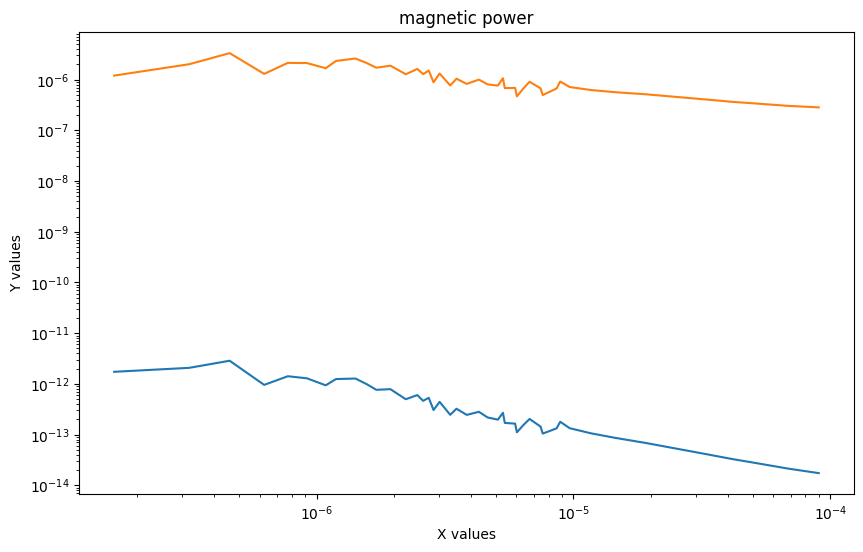

In [6]:
#two estimates for spacecraft voltage (that ended up being identical but took different approaches)!


Zmax_spacecraft = 1/2*mp*(vsolar_wind_kmsec*1e5)**2/estat**2*Rspacecraft_cm  #the maximum charge accumulated
Vmax_spacecraft = estat*Zmax_spacecraft/Rspacecraft_cm  #statvolt

print("spacecraft voltage in volts from Zmax=", statvolttoV*Vmax_spacecraft)

#here is another way of estimating that gives the same
voltagewindeff = 1/2*mp*(vsolar_wind_kmsec*1e5)**2/estat
voltagewindeff_volts = statvolttoV*voltagewindeff

print("spacecraft voltage in volts from Vwindeff=", voltagewindeff_volts)



# Read the Voyager measureemnts of B field power
magfieldpower_nT = np.genfromtxt('OSS_data_files/voyagerBfield.txt')

magfieldpower_nT_los  = magfieldpower_nT[:, 1]/(3.)  #line of sight component and 3 rather than sqrt 3 because this is power
   #Note on change from previous 11/1/24: I had this factor that didn't make sense to me in previous version vsat_kmsec/vvoyaager_8AU_kmsec vvoyaager_8AU_kmsec = 22 #km/s (velocity of Voyagers at 8AU after gravity assist from Jupiter)

nu_bfield, acceleration_bfield_msm2Hzmp5 = 10**magfieldpower_nT [:, 0], cmpermeter*nanoTeslatoGauss*magfieldpower_nT_los**.5*Zmax_spacecraft*estat*(vsat_kmsec/3e5)/mass_spacecraft_g

#print(nu_bfield, acceleration_bfield_msm2Hzmp5, mass_spacecraft_g)

plt.figure(figsize=(10, 6))
plt.loglog(nu_bfield, acceleration_bfield_msm2Hzmp5)
plt.xlabel(r'$\nu$ [Hz]')
plt.ylabel('Power [m s$^{-2}$/$Hz]')
plt.title('Magnetic Field Variations')


# Perform the interpolation
acc_bfield_msm2Hzmp5 = np.interp(freq_arr[freq_arr < nu_bfield[-1]], nu_bfield, acceleration_bfield_msm2Hzmp5)
extrapolation_arr = (freq_arr[freq_arr > nu_bfield[-1]]/nu_bfield[-1])**-1*acceleration_bfield_msm2Hzmp5[-1]
acc_bfield_msm2Hzmp5= np.concatenate((acc_bfield_msm2Hzmp5, extrapolation_arr))

import matplotlib.pyplot as plt
import numpy as np

# Assuming x_values and nanoTeslatoGauss, magfieldpower_nT_los are defined
Bpowergauss = nanoTeslatoGauss * np.sqrt(magfieldpower_nT_los)

plt.loglog(nu_bfield, nu_bfield**.5*Bpowergauss)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('magnetic power')
plt.show()

## Accelerations from density fluctuations in the solar wind

https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2004JA010952


In [7]:
import numpy as np
import re

#function that reads the files that correspond to measurements at different solar radii
def read_file(filename):
    # Open the file
    with open(filename, 'r') as f:
        # Read the first line
        first_line = f.readline()
        # Use regex to extract the distance of Voyager from the header
        distance = float(re.search(r"#(\d+\.?\d*) AU", first_line).group(1))
        print("distance = ", distance)
        # Use genfromtxt to read the rest of the file
        data = np.genfromtxt(f, skip_header=1)
    return distance, data

# List of filenames (each correspond to Voyager measurements at different distances)
filenames = ["OSS_data_files/voyager2_1980.txt", "OSS_data_files/voyager2_1990.txt", "OSS_data_files/voyager2_1997.txt"]

# Dictionary to store the data
data_dict = {}

# Loop over the filenames to create a dictionary for different distances
for filename in filenames:
    # Read the file
    distance, data = read_file(filename)
    # Store the data in the dictionary
    data_dict[distance] = data 

# Initialize an array to store acceleration data for each baseline length
num_baselines = len(baseline_length_arr_AU)
acceleration_drag_msm2Hzmp5_arr = np.zeros((num_baselines, len(freq_arr)))


#power-law fit (used for numerical expression in paper but not plots)
def get_Pdensity_temporal_fit(nu, rAU, beta=2):
    logPe0 = 11.1 #m^-6 Hz^-1
    return 10**logPe0*(nu/1e-5)**-beta*(rAU/30)**-3

# Define the function to interpolate or extrapolate the power spectral density
def logdensityPower(lognu, data, slope=-1.5):
    lognu_min = data[0, 0]
    lognu_max = data[-1, 0]
    logdensityPowerInterp_mm6sm1 = np.zeros_like(lognu)
    
    mask1 = (lognu > lognu_min) & (lognu < lognu_max)
    logdensityPowerInterp_mm6sm1[mask1] = np.interp(lognu[mask1], data[:, 0], data[:, 1])
    
    mask2 = lognu < lognu_min
    logdensityPowerInterp_mm6sm1[mask2] = data[0, 1] + slope * (lognu[mask2] - data[0, 0])  # Extrapolate with a slope motivated by low-frequency measurements
    
    return logdensityPowerInterp_mm6sm1

#just to convert the log power
def get_Pdensity_temporal(nu, data):
    return 10**logdensityPower(np.log10(nu), data)



# Convert density power to accelerations
def get_dragsqrtPower_msm2Hzmp5(nuGW, data):
    Cdrag = 1  # Drag coefficient (ballistic=1, fluids can have different values)
    Pdrag = 10 ** logdensityPower(np.log10(nuGW), data)  # Convert log power to linear scale
    return Cdrag * (vsolar_wind_kmsec * 1e3) ** 2 * 1.22 * mp_kg * Pdrag ** 0.5 * area_spacecraft_drag_msq / mass_spacecraft_kg  #1.22 is because there is helium


# Loop over each baseline length
for i in range(num_baselines):
    baseline_length_AU = baseline_length_arr_AU[i]

    # Find the closest distance to the current baseline length
    closest_distance = min(data_dict.keys(), key=lambda x: abs(x - baseline_length_AU))
    # Get the data for the closest distance
    closest_data = data_dict[closest_distance]


    # Calculate the acceleration due to drag for the current baseline
    acceleration_drag_msm2Hzmp5 = get_dragsqrtPower_msm2Hzmp5(freq_arr, closest_data)

    # Store the acceleration data
    acceleration_drag_msm2Hzmp5_arr[i, :] = acceleration_drag_msm2Hzmp5

    # Print the acceleration at a specific frequency for verification
    acc_at_1e5Hz = get_dragsqrtPower_msm2Hzmp5(1e-5, closest_data)
    print(f"Acceleration drag sqrt power at 1e-5 Hz for baseline {baseline_length_AU} AU: {acc_at_1e5Hz}")

# Now 'acceleration_drag_msm2Hzmp5_arr' contains the acceleration data for each baseline length


distance =  9.0
distance =  31.0
distance =  48.0
Acceleration drag sqrt power at 1e-5 Hz for baseline 10 AU: 1.7848919539005516e-11
Acceleration drag sqrt power at 1e-5 Hz for baseline 30 AU: 1.821763228557071e-12


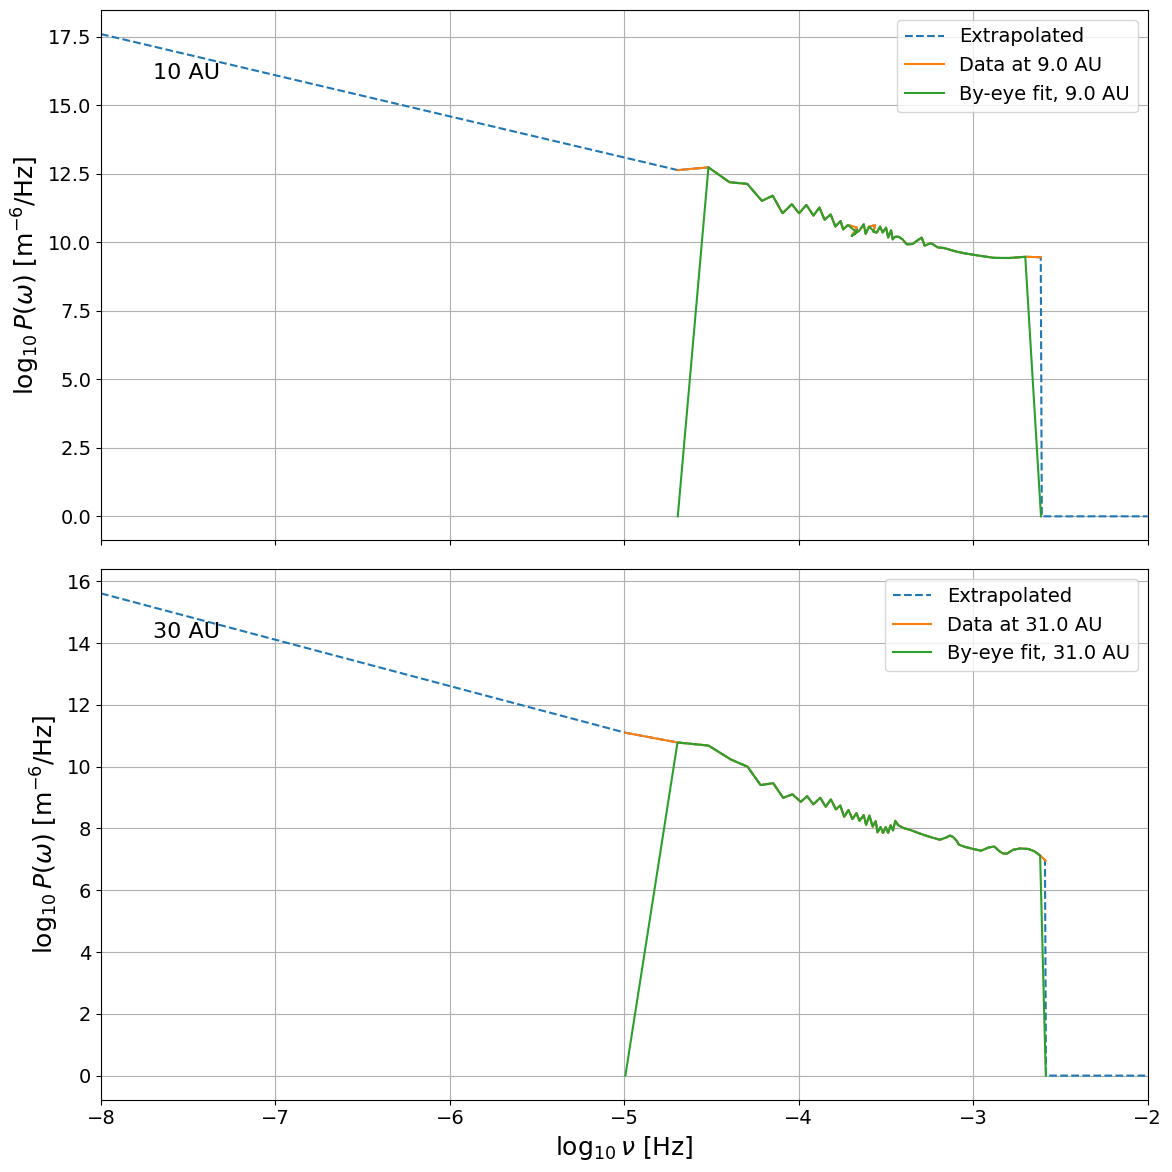

[15.6056     15.59659099 15.58758198 15.57857297 15.56956396 15.56055495
 15.55154595 15.54253694 15.53352793 15.52451892 15.51550991 15.5065009
 15.49749189 15.48848288 15.47947387 15.47046486 15.46145586 15.45244685
 15.44343784 15.43442883 15.42541982 15.41641081 15.4074018  15.39839279
 15.38938378 15.38037477 15.37136577 15.36235676 15.35334775 15.34433874
 15.33532973 15.32632072 15.31731171 15.3083027  15.29929369 15.29028468
 15.28127568 15.27226667 15.26325766 15.25424865 15.24523964 15.23623063
 15.22722162 15.21821261 15.2092036  15.20019459 15.19118559 15.18217658
 15.17316757 15.16415856 15.15514955 15.14614054 15.13713153 15.12812252
 15.11911351 15.1101045  15.1010955  15.09208649 15.08307748 15.07406847
 15.06505946 15.05605045 15.04704144 15.03803243 15.02902342 15.02001441
 15.01100541 15.0019964  14.99298739 14.98397838 14.97496937 14.96596036
 14.95695135 14.94794234 14.93893333 14.92992432 14.92091532 14.91190631
 14.9028973  14.89388829 14.88487928 14.87587027 14.

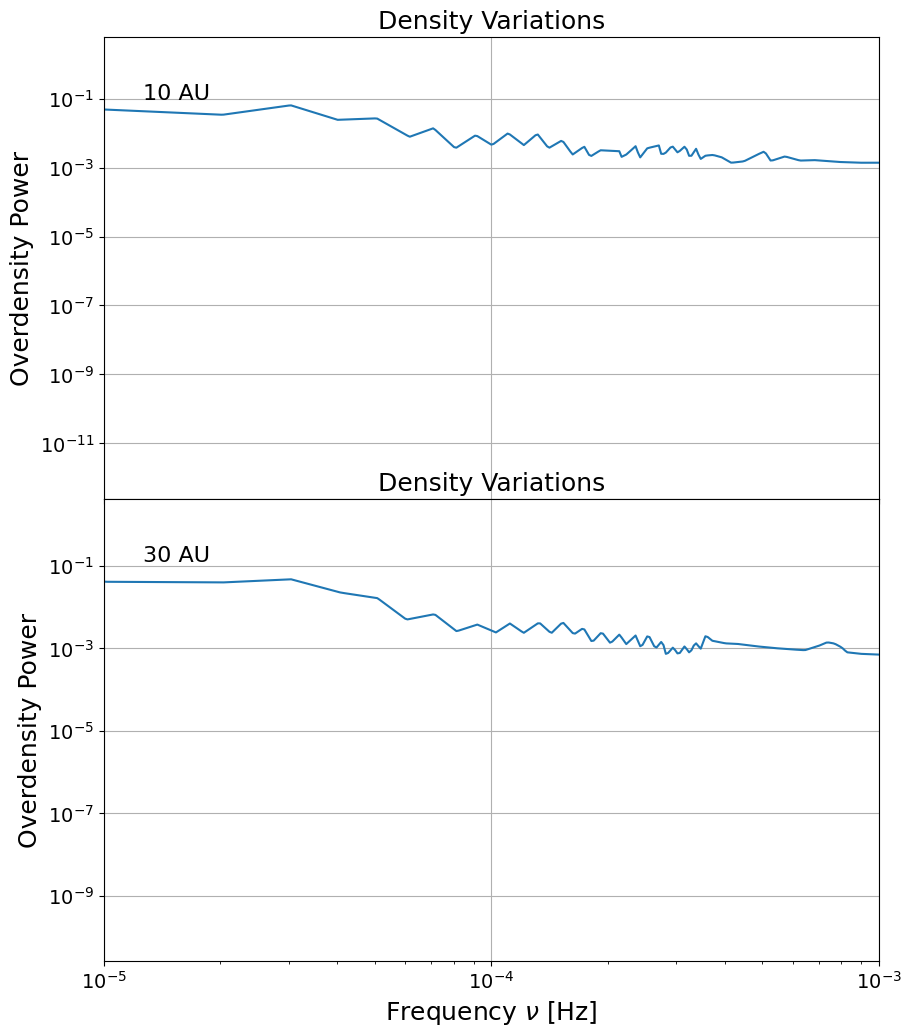

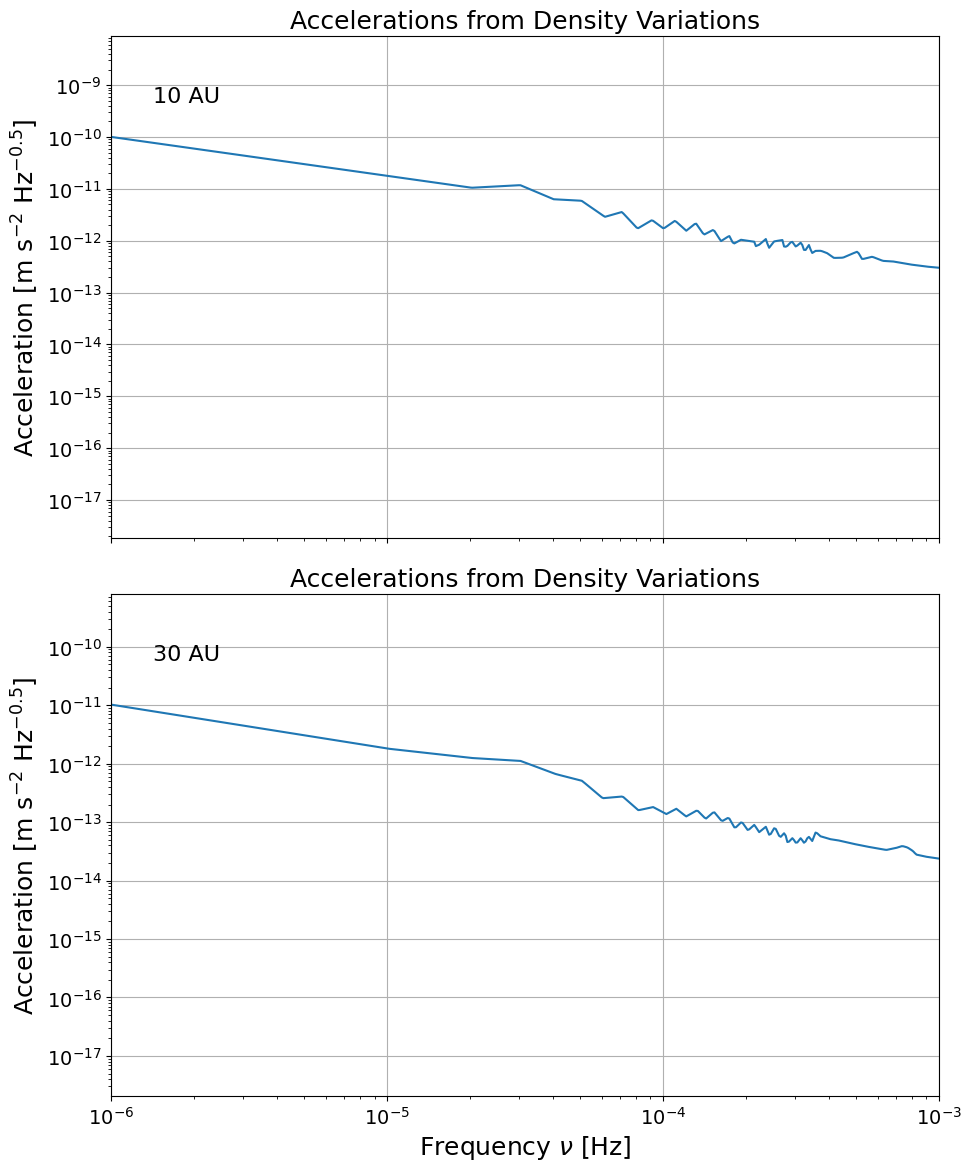

Acceleration at frequencies [1e-05, 1e-06] Hz for baseline 10 AU: [1.78489195e-11 1.00371851e-10]
Acceleration at frequencies [1e-05, 1e-06] Hz for baseline 30 AU: [1.82176323e-12 1.02445275e-11]


In [8]:
########################################################################################################
# Plot the power from solar wind drag
################################################################################################
make_voyager_densitypower_plot = True
if make_voyager_densitypower_plot:
    import matplotlib.pyplot as plt
    plt.rcParams.update({'font.size': 16})

    num_baselines = len(baseline_length_arr_AU)
    fig, axes = plt.subplots(nrows=num_baselines, ncols=1, figsize=(12, 6 * num_baselines), sharex=True)
    plt.subplots_adjust(hspace=0)

    # Loop over each baseline length
    for i in range(num_baselines):
        baseline_length_AU = baseline_length_arr_AU[i]
        ax = axes[i] if num_baselines > 1 else axes

        # Find the closest distance to the current baseline length
        closest_distance = min(data_dict.keys(), key=lambda x: abs(x - baseline_length_AU))
        # Get the data for the closest distance
        closest_data = data_dict[closest_distance]

        # Plot the extrapolated logdensityPower
        lognu = np.log10(freq_arr)
        extrapolated_power = logdensityPower(lognu, closest_data)
        ax.plot(lognu, extrapolated_power, '--', label='Extrapolated')

        # Plot the data from the file
        ax.plot(closest_data[:, 0], closest_data[:, 1], label=f'Data at {closest_distance} AU')

        # Plot the by-eye fit
        by_eye_fit = np.log10(get_Pdensity_temporal(10**closest_data[:, 0], closest_data))
        ax.plot(closest_data[:, 0], by_eye_fit, label=f'By-eye fit, {closest_distance} AU')

        # Set labels and title
        ax.set_ylabel(r'$ \log_{10} P(\omega)$ [m$^{-6}$/Hz]', fontsize=18)
        ax.text(0.05, 0.9, f'{baseline_length_AU} AU', transform=ax.transAxes,
                fontsize=16, verticalalignment='top', horizontalalignment='left')

        # Only set x-axis label on the bottom subplot
        if i == num_baselines - 1:
            ax.set_xlabel(r'$ \log_{10} \nu$ [Hz]', fontsize=18)

        ax.legend(fontsize=14)
        ax.grid(True)
        ax.tick_params(axis='both', which='major', labelsize=14)

        # Set x-limits
        ax.set_xlim([np.log10(freq_arr[0]), np.log10(freq_arr[-1])])

    plt.tight_layout()
    plt.show()

    # Print the extrapolated power for verification
    print(logdensityPower(np.log10(freq_arr), closest_data))

make_solarwinddrag_plot = True
if make_solarwinddrag_plot:
    import matplotlib.pyplot as plt
    plt.rcParams.update({'font.size': 16})

    def ne_SW(r):
        return 5e-2 * (r / 10) ** -2  # cm^-3

    num_baselines = len(baseline_length_arr_AU)
    fig1, axes1 = plt.subplots(nrows=num_baselines, ncols=1, figsize=(10, 6 * num_baselines), sharex=True)
    plt.subplots_adjust(hspace=0)

    fig2, axes2 = plt.subplots(nrows=num_baselines, ncols=1, figsize=(10, 6 * num_baselines), sharex=True)
    plt.subplots_adjust(hspace=0)

    for i in range(num_baselines):
        baseline_length_AU = baseline_length_arr_AU[i]

        # Find the closest distance to the current baseline length
        closest_distance = min(data_dict.keys(), key=lambda x: abs(x - baseline_length_AU))
        closest_data = data_dict[closest_distance]

        # Compute overdensity power
        overdensity_power = freq_arr * 1e-12 * get_Pdensity_temporal(freq_arr, closest_data) / ne_SW(baseline_length_AU) ** 2

        # Plot overdensity power
        ax1 = axes1[i] if num_baselines > 1 else axes1
        ax1.loglog(freq_arr, overdensity_power)
        ax1.set_ylabel('Overdensity Power', fontsize=18)
        ax1.text(0.05, 0.9, f'{baseline_length_AU} AU', transform=ax1.transAxes,
                 fontsize=16, verticalalignment='top', horizontalalignment='left')
        if i == num_baselines - 1:
            ax1.set_xlabel(r'Frequency $\nu$ [Hz]', fontsize=18)
        ax1.grid(True)
        ax1.set_xlim([1e-5, 1e-3])
        ax1.tick_params(axis='both', which='major', labelsize=14)
        ax1.set_title('Density Variations', fontsize=18)

        # Plot acceleration from density variations
        ax2 = axes2[i] if num_baselines > 1 else axes2
        ax2.loglog(freq_arr, acceleration_drag_msm2Hzmp5_arr[i, :])
        ax2.set_ylabel('Acceleration [m s$^{-2}$ Hz$^{-0.5}$]', fontsize=18)
        ax2.text(0.05, 0.9, f'{baseline_length_AU} AU', transform=ax2.transAxes,
                 fontsize=16, verticalalignment='top', horizontalalignment='left')
        if i == num_baselines - 1:
            ax2.set_xlabel(r'Frequency $\nu$ [Hz]', fontsize=18)
        ax2.grid(True)
        ax2.set_xlim([1e-6, 1e-3])
        ax2.tick_params(axis='both', which='major', labelsize=14)
        ax2.set_title('Accelerations from Density Variations', fontsize=18)

    plt.tight_layout()
    plt.show()

# Just to print a check
for i in range(num_baselines):
    baseline_length_AU = baseline_length_arr_AU[i]
    # Find the closest distance
    closest_distance = min(data_dict.keys(), key=lambda x: abs(x - baseline_length_AU))
    closest_data = data_dict[closest_distance]
    # Print the acceleration at specific frequencies
    check_freqs = [1e-5, 1e-6]
    acceleration_check = get_dragsqrtPower_msm2Hzmp5(check_freqs, closest_data)
    print(f"Acceleration at frequencies {check_freqs} Hz for baseline {baseline_length_AU} AU: {acceleration_check}")


# All accelerations plot:  A plot that combines all acceleration calculations!

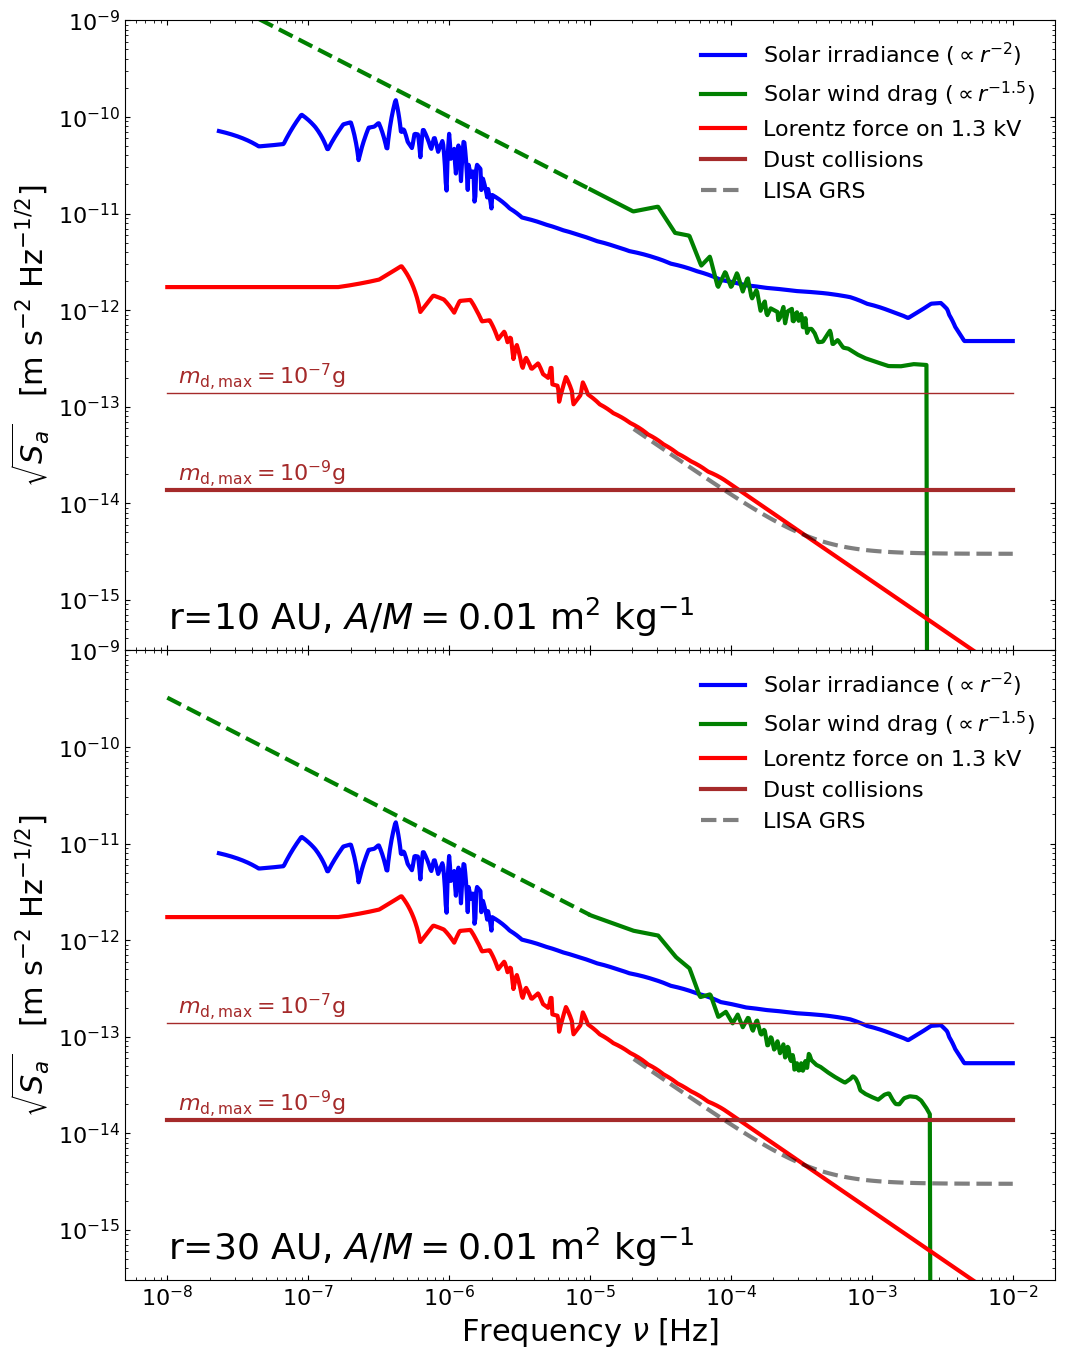

In [9]:
import matplotlib.pyplot as plt
import numpy as np


# Set up the plot with shared x-axis
fig, axes = plt.subplots(nrows=num_baselines, ncols=1, figsize=(12, 7 * num_baselines), sharex=True)
plt.subplots_adjust(hspace=0, top=0.95, bottom=0.05)

plt.rcParams.update({'font.size': 22})


# Acceleration limits (y axis limits of plot)
acc_min = .3e-15  # m/s^2/Hz^0.5
acc_max = 1e-9

# Loop over each baseline length
for i in range(num_baselines):
    baseline_length_AU = baseline_length_arr_AU[i]
    ax = axes[i] if num_baselines > 1 else axes

    # Extract the acceleration arrays for this baseline
    acc_solar_irradiance_msm2Hzmp5 = acc_solar_irradiance_msm2Hzmp5_arr[i, :]
    acceleration_drag_msm2Hzmp5 = acceleration_drag_msm2Hzmp5_arr[i, :]
    #acc_bfield_msm2Hzmp5 = acc_bfield_msm2Hzmp5_arr  #no baseline dependence  
    #acc_dust_msm2Hzmp5 = acc_dust_msm2Hzmp5_arr #no baseline dependence
    #acc_dust_msm2Hzmp5_2 = acc_dust_msm2Hzmp5_2_arr  #no baseline dependence

    # Plot the accelerations
    ax.set_ylim([acc_min, acc_max])

    # Solar irradiance
    ax.loglog(freq_arr, acc_solar_irradiance_msm2Hzmp5, lw=3, color='blue',
              label=r'Solar irradiance ($\propto r^{-2}$)')

    # Solar wind drag
    mask_high_freq = freq_arr > 1e-5
    mask_low_freq = freq_arr <= 1e-5
    ax.loglog(freq_arr[mask_high_freq], acceleration_drag_msm2Hzmp5[mask_high_freq],
              lw=3, color='green', label=r'Solar wind drag ($\propto r^{-1.5}$)')
    ax.loglog(freq_arr[mask_low_freq], acceleration_drag_msm2Hzmp5[mask_low_freq],
              '--', lw=3, color='green')

    # Lorentz force
    ax.loglog(freq_arr, acc_bfield_msm2Hzmp5, lw=3, color="red",
              label=f'Lorentz force on {voltagewindeff_volts / 1e3:.1f} kV')

    # Dust collisions
    ax.loglog(freq_arr, acc_dust_msm2Hzmp5, lw=3, color='brown', label=r'Dust collisions')
    ax.text(1.2 * freq_arr[0], acc_dust_msm2Hzmp5[0],
            r"$m_{{\rm d, max}}= 10^{{-{:.0f}}}$g".format(-np.log10(mmax_dust)),
            ha='left', va='bottom', fontsize=16, color='brown')
    ax.loglog(freq_arr, acc_dust_msm2Hzmp5_2, lw=1, color='brown')
    ax.text(1.2 * freq_arr[0], acc_dust_msm2Hzmp5_2[0],
            r"$m_{{\rm d, max}}= 10^{{-{:.0f}}}$g".format(-np.log10(mmax_dust2)),
            ha='left', va='bottom', fontsize=16, color='brown')

    # Accelerometer sensitivities
    freq_arr_accelerometers = np.logspace(-4.69, np.log10(freq_arr[-1]), 100)

    ## S-GRS accelerometer 
    #s_grs_sensitivity = 4e-13 * (1 + 7e-4 / freq_arr_accelerometers +
    #                             (3e-4 / freq_arr_accelerometers) ** 2) ** 0.5
    #ax.loglog(freq_arr_accelerometers, s_grs_sensitivity, '--', lw=3, color='gray',
    #          alpha=0.5, label='S-GRS accelerometer')
    
    # LISA GRS
    lisa_grs_sensitivity = 3e-15 * np.sqrt(1 + (4e-4 / freq_arr_accelerometers) ** 2)
    ax.loglog(freq_arr_accelerometers, lisa_grs_sensitivity, '--', lw=3, color='black',
              alpha=0.5, label='LISA GRS')

    # Add text with area-to-mass ratio and baseline length
    ax.text(freq_arr[1], 2.2 * acc_min,
            r'r={} AU, $A/M=${:.2f} m$^2$ kg$^{{-1}}$'.format( baseline_length_AU,
                area_spacecraft_irradiance_msq / mass_spacecraft_kg),
            ha='left', va='center', fontsize=26)

    # Set labels and title
    if i == num_baselines - 1:
        ax.set_xlabel(r'Frequency $\nu$ [Hz]', fontsize=22)
    ax.set_ylabel(r'$\sqrt{S_a}$   [m s$^{-2}$ Hz$^{-1/2}$]', fontsize=22)
    ax.legend(fontsize=16, frameon=False, framealpha=0)
    #ax.grid(True)

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', top=True, direction='in')
    ax.tick_params(axis='y', right=True, direction='in')
    ax.tick_params(axis='both', which='minor', direction='in')
    ax.tick_params(axis='x', which='minor', top=True)
    ax.tick_params(axis='y', which='minor', right=True)

    # Add baseline length annotation
    #ax.text(0.05, 0.97, f'r= {baseline_length_AU} AU', transform=ax.transAxes,
    #        fontsize=30, verticalalignment='top', horizontalalignment='left')


#save the figure
# plt.savefig("figures/accelerations_A{}m{}.pdf".format(area_spacecraft_irradiance_msq, mass_spacecraft_kg), format='pdf')

plt.show()


### plot 1 v2

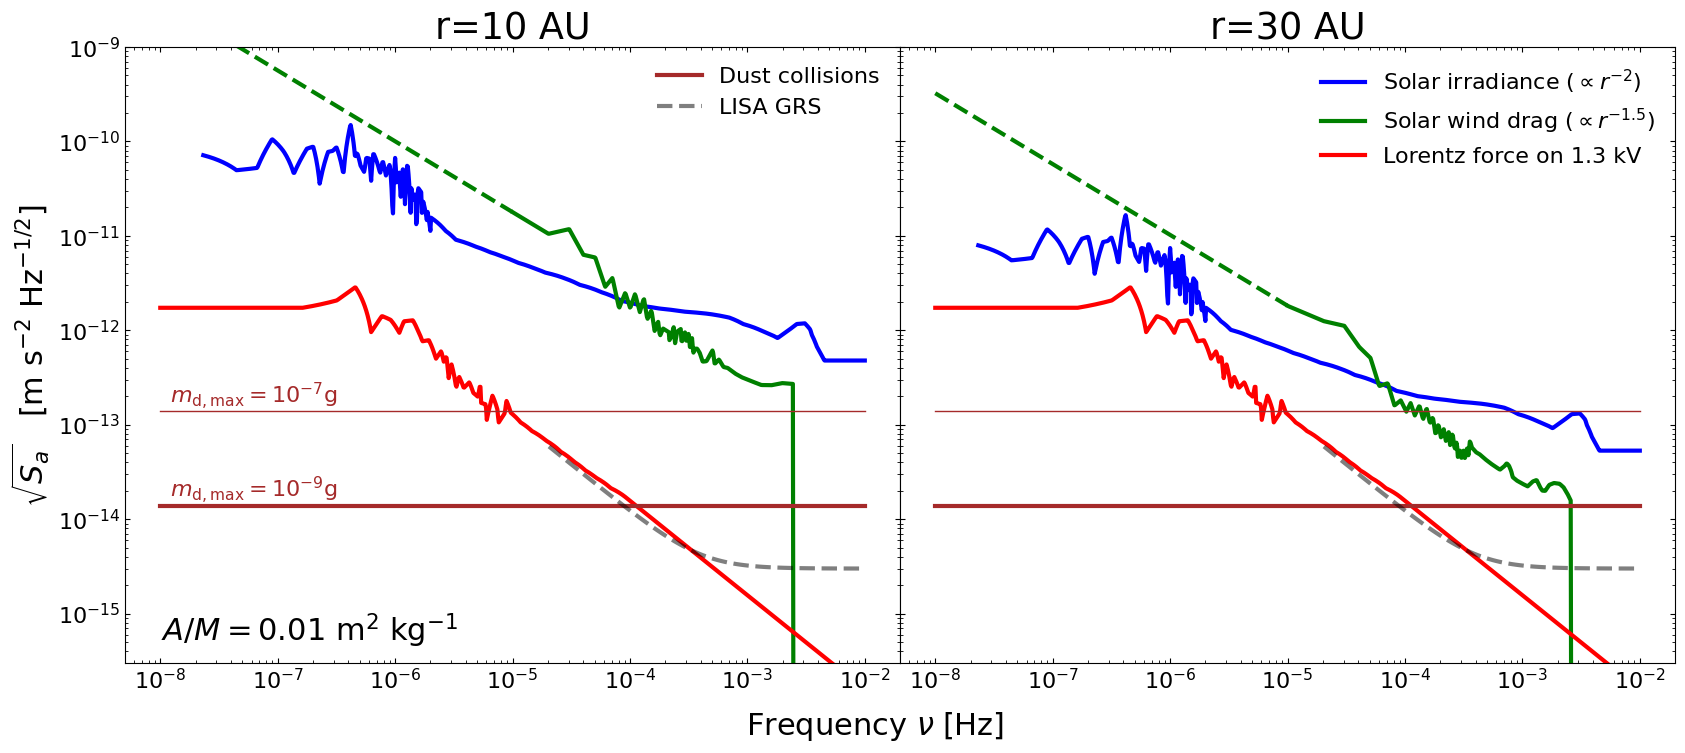

In [10]:
# Set up the plot with shared y-axis
fig, axes = plt.subplots(nrows=1, ncols=num_baselines, figsize=(10 * num_baselines, 4 * num_baselines), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0)#, top=0.95, bottom=0.05)

plt.rcParams.update({'font.size': 22})


# Acceleration limits (y axis limits of plot)
acc_min = .3e-15  # m/s^2/Hz^0.5
acc_max = 1e-9

# Loop over each baseline length
for i in range(num_baselines):
    baseline_length_AU = baseline_length_arr_AU[i]
    ax = axes[i] if num_baselines > 1 else axes

    # Extract the acceleration arrays for this baseline
    acc_solar_irradiance_msm2Hzmp5 = acc_solar_irradiance_msm2Hzmp5_arr[i, :]
    acceleration_drag_msm2Hzmp5 = acceleration_drag_msm2Hzmp5_arr[i, :]

    # Plot the accelerations
    ax.set_ylim([acc_min, acc_max])

    # Solar irradiance
    if i == num_baselines - 1:
        ax.loglog(freq_arr, acc_solar_irradiance_msm2Hzmp5, lw=3, color='blue',
                  label=r'Solar irradiance ($\propto r^{-2}$)')
    else:
        ax.loglog(freq_arr, acc_solar_irradiance_msm2Hzmp5, lw=3, color='blue')

    # Solar wind drag
    mask_high_freq = freq_arr > 1e-5
    mask_low_freq = freq_arr <= 1e-5
    if i == num_baselines - 1:
        ax.loglog(freq_arr[mask_high_freq], acceleration_drag_msm2Hzmp5[mask_high_freq],
                  lw=3, color='green', label=r'Solar wind drag ($\propto r^{-1.5}$)')
    else:
        ax.loglog(freq_arr[mask_high_freq], acceleration_drag_msm2Hzmp5[mask_high_freq],
                  lw=3, color='green')
    ax.loglog(freq_arr[mask_low_freq], acceleration_drag_msm2Hzmp5[mask_low_freq],
              '--', lw=3, color='green')

    # Lorentz force
    if i == num_baselines - 1:
        ax.loglog(freq_arr, acc_bfield_msm2Hzmp5, lw=3, color="red",
                  label=f'Lorentz force on {voltagewindeff_volts / 1e3:.1f} kV')
    else:
        ax.loglog(freq_arr, acc_bfield_msm2Hzmp5, lw=3, color="red",)

    # Dust collisions
    if i == 0:
        ax.loglog(freq_arr, acc_dust_msm2Hzmp5, lw=3, color='brown', label=r'Dust collisions')
        ax.text(1.2 * freq_arr[0], acc_dust_msm2Hzmp5[0],
                r"$m_{{\rm d, max}}= 10^{{-{:.0f}}}$g".format(-np.log10(mmax_dust)),
                ha='left', va='bottom', fontsize=16, color='brown')
        ax.text(1.2 * freq_arr[0], acc_dust_msm2Hzmp5_2[0],
                r"$m_{{\rm d, max}}= 10^{{-{:.0f}}}$g".format(-np.log10(mmax_dust2)),
                ha='left', va='bottom', fontsize=16, color='brown')
    else: 
        ax.loglog(freq_arr, acc_dust_msm2Hzmp5, lw=3, color='brown',)

    ax.loglog(freq_arr, acc_dust_msm2Hzmp5_2, lw=1, color='brown')


    # Accelerometer sensitivities
    freq_arr_accelerometers = np.logspace(-4.69, np.log10(freq_arr[-1]), 100)
    
    # LISA GRS
    lisa_grs_sensitivity = 3e-15 * np.sqrt(1 + (4e-4 / freq_arr_accelerometers) ** 2)
    if i == 0:
        ax.loglog(freq_arr_accelerometers, lisa_grs_sensitivity, '--', lw=3, color='black',
                  alpha=0.5, label='LISA GRS')
    else:
        ax.loglog(freq_arr_accelerometers, lisa_grs_sensitivity, '--', lw=3, color='black',
                  alpha=0.5,)

    # Add text with area-to-mass ratio
    if i ==0:
        ax.text(freq_arr[1], 2.2 * acc_min,
                r'$A/M=${:.2f} m$^2$ kg$^{{-1}}$'.format(area_spacecraft_irradiance_msq / mass_spacecraft_kg),
                ha='left', va='center', fontsize=22)
    
    # Set labels and title
    ax.set_title(r'r={} AU'.format(baseline_length_AU))
    
    if i == 0:
        ax.set_ylabel(r'$\sqrt{S_a}$   [m s$^{-2}$ Hz$^{-1/2}$]', fontsize=22)
    # ax.set_xlabel(r'Frequency $\nu$ [Hz]', fontsize=22)
    ax.legend(fontsize=16, frameon=False, framealpha=0)
    # ax.grid(True)

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', top=True, direction='in')
    ax.tick_params(axis='y', right=True, direction='in')
    ax.tick_params(axis='both', which='minor', direction='in')
    ax.tick_params(axis='x', which='minor', top=True)
    ax.tick_params(axis='y', which='minor', right=True)


fig.supxlabel(r'Frequency $\nu$ [Hz]', fontsize=22)

#save the figure
# plt.savefig("figures/accelerations_A{}m{}.pdf".format(area_spacecraft_irradiance_msq, mass_spacecraft_kg), format='pdf')
# plt.savefig("/Users/cdmcgrat/Desktop/matt_updated_figs/fig1.pdf", bbox_inches='tight', format='pdf')

plt.show()


# Effect of dispersion from plasma wind on GW noise

In [11]:
#Cnsqincm = Cnsq_SI*100**(-20/3)  #converting to cmsquared

#see appendix; coefficient to calculate dispersion in CGS
def kappa(nuGHz): 
    return estat**2/( 2*np.pi*me*lightspeed*(10**9*nuGHz)**2)  #coeffient for scattering time;  have \checked that \[Kappa][1] 10^3parsec is 4 seconds*)

#This is the delay from the total column of electrons
def total_delay_dispersion():
    return kappa(nuGHz)*ne_solarwind(baseline_length_AU)*baseline_length_AU*AU_in_cm


# this is equation C13 in McQuinn and Boone.  It gives the variance with time given a turbulent spectrum
#currently conversion between 1D and 3D is primative#
def sigmaDispersion(t):
    return 9.4*kappa(nuGHz)*(baseline_length_AU*AU_in_cm)**.5*(vsolar_wind_kmsec*1e5*t)**(5/6)*(Cnsqincm)**(1/2)  #seconds

#calculates the gravitational strain error from dispersion  (1.5 is a coeficient calculated in paper)
def getherror_dispersion(nuGW, baseline_length_AU, nuGHz):
    closest_distance = min(data_dict.keys(), key=lambda x: abs(x - baseline_length_AU))
    Ptau = 1.5*get_Pdensity_temporal(nuGW, data_dict[closest_distance])/mcubetocmcube**2*kappa(nuGHz)**2*(baseline_length_AU*AU_in_cm)*(vsolar_wind_kmsec*1e5)/nuGW

    return lightspeed*np.sqrt(4*Ptau)/(baseline_length_AU*AU_in_cm)

#same as above but for a power-law  (1.5 is a coeficient calculated in paper)
def getherror_dispersion_simplepowerlaw(nuGW, baseline_length_AU, nuGHz):
    closest_distance = min(data_dict.keys(), key=lambda x: abs(x - baseline_length_AU))
    Ptau = 1.5*get_Pdensity_temporal_fit(nuGW, baseline_length_AU)/mcubetocmcube**2*kappa(nuGHz)**2*(baseline_length_AU*AU_in_cm)*(vsolar_wind_kmsec*1e5)/nuGW

    return lightspeed*np.sqrt(4*Ptau)/(baseline_length_AU*AU_in_cm)


#the phase errror from the plasma wind dispersion
def phaseErrorDispfluctuations(nuGW,  baseline_length_AU, nuGHz, simplepowerlaw=False):
    lambda0=lightspeed/(nuGHz*1e9)
    if simplepowerlaw:
         return 2*np.pi*getherror_dispersion_simplepowerlaw(nuGW, baseline_length_AU, nuGHz)*(baseline_length_AU*AU_in_cm)/(lambda0)
    else:
        return 2*np.pi*getherror_dispersion(nuGW, baseline_length_AU, nuGHz)*(baseline_length_AU*AU_in_cm)/(lambda0)





#the (small) efect of refraction on phase error  (note that 100 is a constant justified in paper)
def getherror_refraction(nuGW, baseline_length_AU, nuGHz, multfactorlambda2=2):
    lambda1 = lightspeed/(nuGHz*1e9)
    kappaprime = kappa(nuGHz)*2*np.pi*lightspeed/lambda1
    rfresnel = np.sqrt(lambda0*baseline_length_AU*AU_in_cm/(4*np.pi)) #puts halfway between
    closest_distance = min(data_dict.keys(), key=lambda x: abs(x - baseline_length_AU))
    Pphi = 100*rfresnel**4*kappaprime**4*(baseline_length_AU*AU_in_cm)**2/(vsolar_wind_kmsec*1e5)**2*nuGW**3*(get_Pdensity_temporal(nuGW, data_dict[closest_distance])/mcubetocmcube**2)**2
    
    lambda2 = multfactorlambda2*lambda1

    flambda = np.abs(lambda2/lambda1**3/(lambda1**2 - lambda2**2)*(lambda1*lambda2**3 - lambda2*lambda1**3))

    print("omega_fresnel =", (vsolar_wind_kmsec*1e5)/ rfresnel,  "flambda =", flambda)

    return flambda*lambda1*np.sqrt(4*Pphi)/(2*np.pi*baseline_length_AU*AU_in_cm)



print("baseline length = ", baseline_length_AU)


print("total delay from dispersion in seconds=", total_delay_dispersion(), total_delay_dispersion()*lightspeed/(baseline_length_AU*AU_in_cm))
print("")

print("total phase from dispersion in sqrt(nu*power) at 1e-6 and 1e-5 and 10 Hz=",  1e-6**.5*phaseErrorDispfluctuations(1e-6, baseline_length_AU, nuGHz),  1e-5**.5*phaseErrorDispfluctuations(1e-5,  baseline_length_AU, nuGHz),  10**.5*phaseErrorDispfluctuations(10,  baseline_length_AU, nuGHz))
print("total phase homogeneous ", total_delay_dispersion()*2*np.pi*nuGHz*1e9, r" for $\nu=$", nuGHz, "GHz")
print("")

print("sigma h from dispersion in sqrt(power) at 1e-6 and 1e-5 Hz=", getherror_dispersion(1e-6, baseline_length_AU, nuGHz), getherror_dispersion(1e-5, baseline_length_AU, nuGHz))
print("sigma h from dispersion in sqrt(nu*power) at 1e-6 and 1e-5 Hz=", 1e-6**.5*getherror_dispersion(1e-6, baseline_length_AU, nuGHz), 1e-5**.5*getherror_dispersion(1e-5, baseline_length_AU, nuGHz))

print("simple power law: sigma h from dispersion in sqrt(power) at 1e-6 and 1e-5 Hz=", getherror_dispersion_simplepowerlaw(1e-6, baseline_length_AU, nuGHz), getherror_dispersion_simplepowerlaw(1e-5, baseline_length_AU, nuGHz))


#omega = 1e-5
#print(9.4**2*(vsolar_wind_kmsec*1e5)**(5/3)*(2.606)/(omega)**(8/3), 4/(1+alpha)*omega/(vsolar_wind_kmsec*1e5)**2*(2*np.pi)**3*(omega/(vsolar_wind_kmsec*1e5))**(-5/3-2), Cnsq_SI*100**(-20/3), Cnsqincm)

#estimate for correct to this
Rfresnel = np.sqrt(baseline_length_AU*AU_in_cm*lambda0/2*np.pi)  #should really divide by two
correction1 = Rfresnel**2*(1e-5/(vsolar_wind_kmsec*1e5))**2; correction2 = Rfresnel**2*(1e-6/(vsolar_wind_kmsec*1e5))**2; 
#print("sigma h from dispersion in sqrt(power) at 1e-6 and 1e-5 Hz=", herror(1e-6, alpha)*correction2, herror(1e-5, alpha)*correction1, correction2, correction1, "Rfresel =", Rfresnel, Rfresnel/(vsolar_wind_kmsec*1e5))


print("refraction error = ", getherror_refraction(1e-5, baseline_length_AU, nuGHz, multfactorlambda2=2),  (1e-5)**.5*getherror_refraction(1e-5, baseline_length_AU, nuGHz, multfactorlambda2=2))

print("refraction errro = ", getherror_refraction(1e-6, baseline_length_AU, nuGHz, multfactorlambda2=2),  (1e-6)**.5*getherror_refraction(1e-6, baseline_length_AU, nuGHz, multfactorlambda2=2))

baseline length =  30
total delay from dispersion in seconds= 3.724635578048079e-12 2.4879868537055115e-16

total phase from dispersion in sqrt(nu*power) at 1e-6 and 1e-5 and 10 Hz= 0.2074873475214184 0.0368970477940929 1.0332171798050024e-07
total phase homogeneous  0.702077266157701  for $\nu=$ 30 GHz

sigma h from dispersion in sqrt(power) at 1e-6 and 1e-5 Hz= 7.352834478870035e-14 4.134802684753066e-15
sigma h from dispersion in sqrt(nu*power) at 1e-6 and 1e-5 Hz= 7.352834478870035e-17 1.307539415919886e-17
simple power law: sigma h from dispersion in sqrt(power) at 1e-6 and 1e-5 Hz= 1.299136514630797e-13 4.108230377725981e-15
omega_fresnel = 8.36952032790987 flambda = 4.0
omega_fresnel = 8.36952032790987 flambda = 4.0
refraction error =  2.9039157214571776e-27 9.182987812975775e-30
omega_fresnel = 8.36952032790987 flambda = 4.0
omega_fresnel = 8.36952032790987 flambda = 4.0
refraction errro =  2.9039157214571772e-27 2.9039157214571772e-30


# Code to calculate transfer function response for gravitational waves

This is eqn 34 in Larson, Hiscock and Hellings 2000 (https://journals.aps.org/prd/pdf/10.1103/PhysRevD.62.062001)

defaults to 90degree orientation for two arm case (need to pass an extra argument to do other orientations)

It's easy to pull out the 1 arm contribution to there calculation

omega tau= 0.00031354098600822777
omega tau= 0.00031790717202478486
omega tau= 0.0003223341589611007
omega tau= 0.00032682279349476165
omega tau= 0.0003313739340936871
omega tau= 0.0003359884511803094
omega tau= 0.00034066722729804997
omega tau= 0.0003454111572801073
omega tau= 0.0003502211484205944
omega tau= 0.0003550981206480679
omega tau= 0.0003600430067014613
omega tau= 0.00036505675230848
omega tau= 0.0003701403163664735
omega tau= 0.00037529467112582514
omega tau= 0.0003805208023759042
omega tau= 0.0003858197096335956
omega tau= 0.0003911924063344669
omega tau= 0.00039663992002658845
omega tau= 0.00040216329256705417
omega tau= 0.00040776358032124587
omega tau= 0.00041344185436486056
omega tau= 0.00041919920068876317
omega tau= 0.0004250367204066843
omega tau= 0.0004309555299658091
omega tau= 0.00043695676136030874
omega tau= 0.0004430415623478306
omega tau= 0.000449211096669018
omega tau= 0.0004554665442700769
omega tau= 0.0004618091015284425
omega tau= 0.0004682399814815968
om

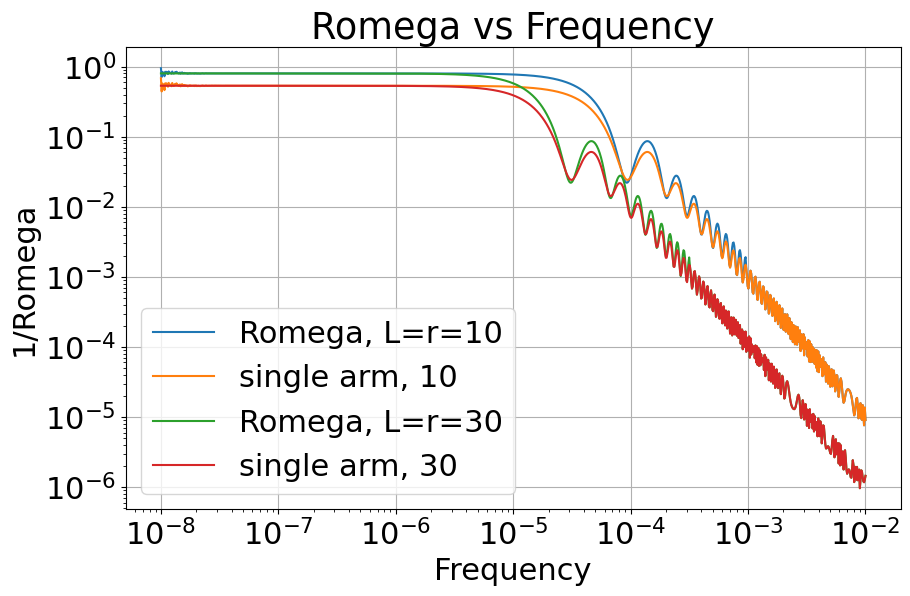

In [12]:
#from mpmath import mp
from scipy.integrate import dblquad

#transfer function on power and not its square root.  Took out the 1/(nu*tau)^2 and multiplied by another (nu*tau)^2 from their expression since theirs is on acceleration  (the expression asymptotes to four at low frequencies)
def Romega(nuGW, L_in_AU, gamma=np.pi/2, evaluate_integrand=False, armstrong_clock_mission_est=False):#currently this is for orthogonal arms
    tau = L_in_AU*AU_in_cm/lightspeed
    omega = 2*np.pi*nuGW

    integralexpresssion= 0 # this is the last term in eqn 34, that is zero if wave is perpendicular to arms

    #ot is omega*tau
    def eta(ot, mu1, mu2):
        return (np.cos(ot) - np.cos(ot*mu1))*(np.cos(ot) - np.cos(ot*mu2))*mu1*mu2 + (np.sin(ot) - mu1*np.sin(ot*mu1))*(np.sin(ot) - mu2*np.sin(ot*mu2))
    
    def integrand(epsilon, theta1, ot, gamma):
        mu1 = np.cos(theta1)
        mu2 = np.cos(gamma)*np.cos(theta1)+np.sin(gamma)*np.sin(theta1)*np.cos(epsilon)
        theta2=  np.arccos(mu2)
        #print("theta2=", theta2, "epsilon=", epsilon, "theta1=", theta1, "mu1=", mu1, "mu2=", mu2, "gamma=", gamma, "alpha=", alpha, "sinalpha=", np.sin(alpha))
        sinalpha =  np.sin(gamma)*np.sin(epsilon)/(np.sin(theta2) +1e-10)
    
        return eta(ot, mu1, mu2)*np.sin(theta1)*(1-2.*sinalpha**2)/(4*np.pi)


    #defaults to 90degree arms
    def integralexpresssion(ot, gamma=np.pi/2): #currently this is for orthogonal arms
        print("omega tau=", ot)
       # Define the limits of integration
        epsilon_limits = [0, np.pi]
        theta1_limits = [0, 2*np.pi]

        # Perform the double integration
        result, error = dblquad(integrand, epsilon_limits[0], epsilon_limits[1], 
                        lambda epsilon: theta1_limits[0], lambda epsilon: theta1_limits[1], 
                        args=(ot, gamma), epsabs=1e-8, epsrel=1e-8)
        return result
        

    #print("stuff = ", integralexpresssion(.1, gamma=np.pi/2), integrand(1, 1, .1, 1.5))
    # Set the precision
    #mp.dps = 50  # 50 digits of precision
    ot_array = omega*tau



    integralexpresssion_results = 0

    if evaluate_integrand: #not so important for large omega*tau
        if np.isscalar(ot_array):
             integralexpresssion_results = integralexpresssion(ot_array, gamma)
        else:
            integralexpresssion_results = np.array([integralexpresssion(ot, gamma) if ot < 30 else 0 for ot in ot_array])  #I find this correction is not so important at high omega*tau, although I haven't tested it for gamma!=pi/2
                               #calculation slows down considerably at high omega*tau 

    #omega = mp.mpf(omega)  # convert to high precision
    #tau = mp.mpf(tau)  # convert to high precision
    if armstrong_clock_mission_est:
        return [(omega*tau)**-2*((1+np.cos(omega*tau)**2)*(-2/(omega*tau)**2) + 4/(omega*tau)**3*np.sin(omega*tau)*np.cos(omega*tau)), 0]  #not accounting for radiometer noise or acceleration noise, which will be diffferent
    
    else:
        return [(omega*tau)**-2*((1+np.cos(omega*tau)**2)*(1/3-2/(omega*tau)**2)+np.sin(omega*tau)**2 + 4/(omega*tau)**3*np.sin(omega*tau)*np.cos(omega*tau) -integralexpresssion_results), integralexpresssion_results]


#print("romega = ", Romega(1e-5, 10),  Romega(1e-5, 10, evaluate_integrand=True))



# Loop over each baseline length
# Create the plot
plt.figure(figsize=(10, 6))
Romega_values_arr = np.zeros((num_baselines, len(freq_arr)))
Romega_values_singlearm_arr = np.zeros((num_baselines, len(freq_arr)))
Romega_values_armstrongclock_arr = np.zeros((num_baselines, len(freq_arr)))
for i in range(num_baselines):
    baseline_length_AU = baseline_length_arr_AU[i]
    # Calculate the values
    Romega_values_arr[i,:], integralexpresssion_results = Romega(freq_arr, baseline_length_AU, evaluate_integrand=True) #rather slow when evaluate_integrand=True
    Romega_values_singlearm_arr[i, :] = Romega(freq_arr, baseline_length_AU, evaluate_integrand=False)[0] #no integrand -- which is same as single arm once dividing by two 
        #might think should divide single arm by another factor of two, but I'm keeping this to cancel the factor of two higher noise that is assumed for two arms


    #my attempt to calculate transfer function for Armbstrong's clock estimator, but realized it was incorrect
    #and calculation is much harder
    #Romega_values_armstrongclock_arr[i, :] = Romega(freq_arr, baseline_length_AU, evaluate_integrand=False, armstrong_clock_mission_est=True)[0]



    plt.loglog(freq_arr, Romega_values_arr[i,:], label=f'Romega, L=r={baseline_length_AU}')
    plt.loglog(freq_arr, Romega_values_singlearm_arr[i,:], label=f'single arm, {baseline_length_AU}')
    #plt.loglog(freq_arr, Romega_values_armstrongclock_arr[i,:], label=f'clock mission, {baseline_length_AU}')
    plt.xlabel('Frequency')
    plt.ylabel('1/Romega')
    plt.title('Romega vs Frequency')
    plt.grid(True)


plt.legend()
plt.show()
#print( Romega_values, Romega_values_singlearm, integralexpresssion_results)

# Now let's consider astrophysical sources

In [13]:
#using uncorrected background from here:  https://arxiv.org/pdf/1201.4613 eqn 6.  Correction can be quite large though
#they only look at >1e-4 Hz, so extrapolation may be problematic
def hnuwhiteDwarfBinariesUncorrected(nuGW):
    Dchar = 6.4 #kpc
    Rgal = .015 #binary merger rate per year in galaxy
    Mzchar = 0.35#Solar masses is the characteristic churp mass
    
    Sh =4.9e-44*nuGW**-(7/3)*(Dchar/6.4)**-2*(Rgal/.015)*(Mzchar/.35)**(5/3)
    
    return np.sqrt(Sh)

#This one is from https://arxiv.org/pdf/1703.09858 and really here https://arxiv.org/pdf/1803.01944
def hnubinariesCornish(nuGW):
    #4 year paramaeters for LISA
    alpha = 0.138
    beta = -221
    kappa = 521
    gamma =1680
    fk = 0.00113
    Snu = 9e-45*nuGW**-(7/3)*np.exp(-nuGW**alpha+beta*nuGW*np.sin(kappa*nuGW))*(1+np.tanh(gamma*(fk-nuGW))) 

    return np.sqrt(Snu)

# from Nanograv detection https://arxiv.org/pdf/2306.16213
def characteristicStrainPTAs(nuGW):
    gamma = 2/3 #assumes supermassive blakc hole like form and
    return 2.4e-15*(secinyear*nuGW)**(-gamma)
    #(2.4 + [-0.6,0, 0.7])*e-15*nu**(-gamma)  #this would return the lwoer and upper


#MBH backgournd: only valid to nu <3e-5 taken from Figure 1 in https://arxiv.org/pdf/1908.11391
#I don't use this in the end
def massiveBHbackground(nuGW):
    logh = np.log10(1.2e-16) + np.log10(nuGW/1e-7)*np.log10(7e-20/1.2e-16)/np.log10(3e-5/1e-7)
    
    return 10**logh

#supermassive black hole mergers using hte formula from Ajith et al 2007 and really https://arxiv.org/pdf/1803.01944
def characteristicStrainMBH(nuGWz, M1_solar, M2_solar, DL_Mpc=6481.1, z=3):

    nuGW = nuGWz*(1+z)
    GNewton = 6.67430e-8 #cgs units (cm^3 g^-1 s^-2)
    mpcincm = 3.08567758e24
    Msun = 1.989e33 #grams


    M1 = M1_solar*Msun
    M2 = M2_solar*Msun  
    Mchirp = (M1*M2)**(3/5)/(M1+M2)**(1/5)
    tauchirp = GNewton*Mchirp/(lightspeed**3)
    tautot = GNewton*(M1+M2)/(lightspeed**3)
    eta = M1*M2/(M1+M2)**2

    # Coefficients from Table 2
    avec = np.array([2.9740e-1, 5.9411e-1, 5.0801e-1, 8.4845e-1])
    bvec = np.array([4.4810e-2, 8.9794e-2, 7.7515e-2, 1.2848e-1])
    cvec = np.array([9.5560e-2, 1.9111e-1, 2.2369e-2, 2.7299e-1])

    nuvec = (avec*eta**2 + bvec*eta + cvec)/(np.pi*tautot)

    #print(nuvec)


    hcoef = np.sqrt(16/5)*np.sqrt(5/24) * (tauchirp)**(5/6) * nuvec[0]**(-7/6) * nuGW / (np.pi**(2/3) * DL_Mpc * mpcincm / lightspeed)
    
    if nuGW < nuvec[0]:
        return hcoef*(nuGW/nuvec[0])**(-7/6)
    elif nuGW <nuvec[1]:
        return hcoef*(nuGW/nuvec[0])**(-2/3)
    elif nuGW < nuvec[3]:
        return hcoef*(nuvec[0]/nuvec[1])**(2/3)/(4*(nuGW - nuvec[1])**2/nuvec[2]**2 + 1)
    else:
        return 0
    

# frequency of BH-BH GW emission in years before merger
def frequencyMB( M1_solar, M2_solar, tbeforemerger_year, z=3):

    dt = tbeforemerger_year*secinyear/(1+z)

    GNewton = 6.67430e-8 #cgs units (cm^3 g^-1 s^-2)
    Msun = 1.989e33 #grams

    M1 = M1_solar*Msun
    M2 = M2_solar*Msun  
    Mchirp = (M1*M2)**(3/5)/(M1+M2)**(1/5)
    tauchirp = GNewton*Mchirp/(lightspeed**3)


    nu = 1/(8*np.pi*tauchirp)*(5*tauchirp/dt)**(3/8)

    return nu/(1+z)


#cf eqn 29 in https://arxiv.org/pdf/1408.0740
def omega_to_char_strain(nu, omega_gw, H0=2.27e-18):
    """
    Convert gravitational wave energy density spectrum Omega_gw(nu)
    to characteristic strain h_c(nu).

    Parameters:
    - nu: array-like
        Frequencies in Hz.
    - omega_gw: array-like
        Gravitational wave energy density spectrum (dimensionless).
    - H0: float, optional
        Hubble constant in s^{-1}. Default is 2.27e-18 s^{-1} (approximately 70 km/s/Mpc).

    Returns:
    - h_c: array-like
        Characteristic strain corresponding to the input frequencies.
    """
    # Ensure inputs are NumPy arrays
    nu = np.array(nu, dtype=float)
    omega_gw = np.array(omega_gw, dtype=float)

    # Compute the characteristic strain using the provided formula
    numerator = 3 * H0**2
    denominator = 2 * np.pi**2 * nu**2
    h_c = np.sqrt((numerator / denominator) * omega_gw)

    return h_c

#massivebinary background

# Read the data from the file
data = np.genfromtxt('GW_background_estimates/OmegaGWpernasto.txt', delimiter=',', comments='#')

# Extract x and y values
nuMBHs = data[:, 0]
OmegaGW = data[:, 1]
renormtoptas = 1 #4
characteristic_strain_MBHs = renormtoptas*omega_to_char_strain(nuMBHs, OmegaGW)

## Radiometer noise

see section 3 in paper (see formula there to understand)

In [14]:
#radiometer noise in long wavelength limit
def strainNoiseShotorThermal(CoverN_dbHz, lambda0, baseline_length_AU, A=1):
    #A is the increase in the error from dispersion
    
    #lambda0 = lightspeed/(nuGHz*1e9)

    dphase =  1/10**(CoverN_dbHz/20)  #this is because C/N =  10^(CoverN_dbHz/10) and the phase noise is 1/sqrt(C/N)
    return 2*A*dphase/(2*np.pi)*lambda0/(baseline_length_AU*AU_in_cm)
        #the factor of two is beause there are two detectors in each arm (one sqrt of 2) and the other is because there are two arms in the measurement
        # (see Larson, Hiscock and Hellings 2000)


#given ana cceleration power, this calculates the noise in the long wavelength limit
def accelerationNoiseStrain(nu_GW, acc_noise_msm2Hzmp5, baseline_length_AU):
    x = baseline_length_AU*AU_in_meter

    nu_star = lightspeed/(2*np.pi*x)
    return np.sqrt(2)*2*(1+np.cos(nu_GW/nu_star)**2)**.5 *acc_noise_msm2Hzmp5/(2*np.pi*nu_GW)**2/(x)  #the two is because each detector contributes twice 
               #and the cosine is because there are two detectors (see Larson, Hiscock and Hellings 2000)


#noise from pulsed lasers from https://arxiv.org/pdf/2112.11431, eqn 94
#evaluated at their fiducial values and this is Hz^-1 and not nu hnu like they considered
#(see section 2.2 in paper)
def strainnoisepulsedlaser(L_AU=1, lambda0=1e-4, Dtel=150, Plaser=1):
    hplanck_cgs = 6.626176e-27/(2*np.pi)
    return (2*np.pi)**1.5*np.sqrt(1/lightspeed)*(L_AU*AU_in_cm)**2*lambda0**1.5/(Dtel**6*(Plaser*watttoerg/hplanck_cgs/lightspeed**2)**1.5)


# Now let's make plots for strain constraints

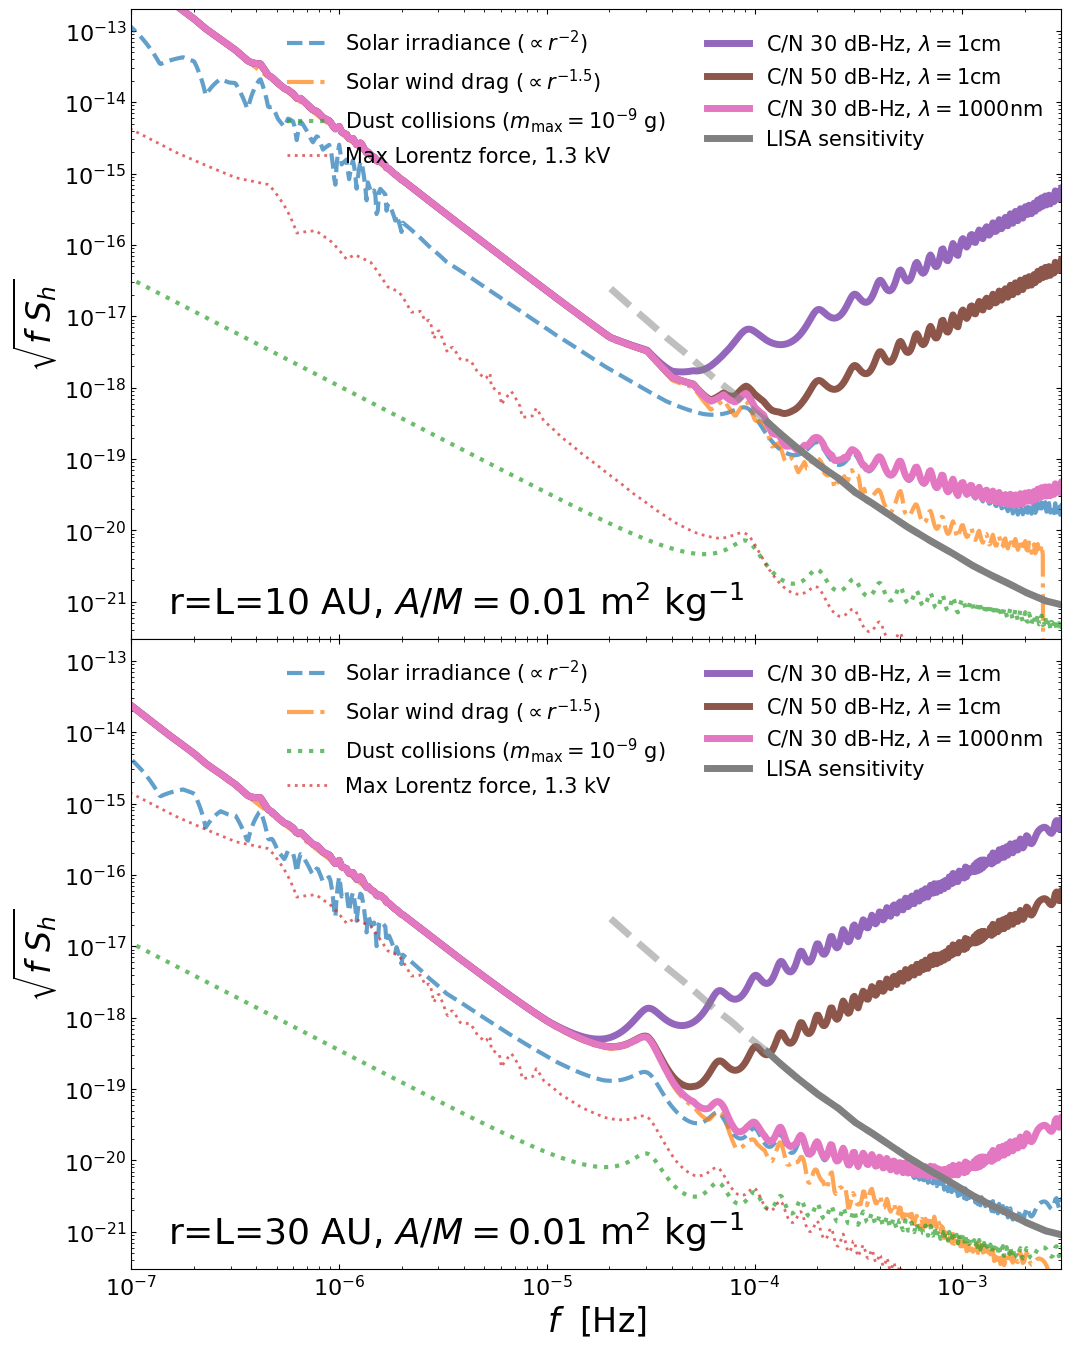

In [15]:
geometric_suppression = 0.5
show_dBHz = False
show_total = True
show_dispersion = False
only_show_acceleration_total = False

alpha_dB = 1  # opacity of laser curve
acc_width = 3 #width of lines for accelerations
             
             
# Create subplots with shared x-axis
fig, axes = plt.subplots(nrows=num_baselines, ncols=1, figsize=(12, 7 * num_baselines), sharex=True)
plt.subplots_adjust(hspace=0, top=0.95, bottom=0.05)
plt.rcParams.update({'font.size': 20})

# Loop over each baseline length
for i in range(num_baselines):
    baseline_length_AU = baseline_length_arr_AU[i]
    ax = axes[i] if num_baselines > 1 else axes

    # Extract the transfer function and compute the window function
    Romega_values = Romega_values_arr[i, :]
    window = Romega_values ** 0.5  #window applies in strain space rather to power

    # Extract the acceleration arrays for this baseline
    acc_solar_irradiance_msm2Hzmp5 = acc_solar_irradiance_msm2Hzmp5_arr[i, :]
    acceleration_drag_msm2Hzmp5 = acceleration_drag_msm2Hzmp5_arr[i, :]
    #acc_bfield_msm2Hzmp5 = acc_bfield_msm2Hzmp5_arr[i, :]
    #acc_dust_msm2Hzmp5 = acc_dust_msm2Hzmp5_arr[i, :]
    #acc_dust_msm2Hzmp5_2 = acc_dust_msm2Hzmp5_2_arr[i, :]

    # Set the y-axis range
    acc_min = 3e-22  # Adjusted to match the strain units
    acc_max = 2e-13
    ax.set_ylim([acc_min, acc_max])

    # Calculate the noise sources for the current baseline
    noise_30dBHz = strainNoiseShotorThermal(30, lambda0, baseline_length_AU, A=radio_enhancement_beamnoise)
    noise_50dBHz = strainNoiseShotorThermal(50, lambda0, baseline_length_AU, A=radio_enhancement_beamnoise)
    noise_30dBHz_laser = strainNoiseShotorThermal(30, 10000*1e-8, baseline_length_AU)
    # You can add more noise calculations as needed

    # Calculate the acceleration noise strains for different sources
    irradiance = accelerationNoiseStrain(freq_arr, acc_solar_irradiance_msm2Hzmp5, baseline_length_AU) * geometric_suppression
    drag = accelerationNoiseStrain(freq_arr, acceleration_drag_msm2Hzmp5, baseline_length_AU) * geometric_suppression
    dust = accelerationNoiseStrain(freq_arr, acc_dust_msm2Hzmp5, baseline_length_AU)
    lorentz = accelerationNoiseStrain(freq_arr, acc_bfield_msm2Hzmp5, baseline_length_AU)

    # Plotting the acceleration noise strains
    if not only_show_acceleration_total:
        # Solar irradiance
        ax.loglog(freq_arr, freq_arr ** 0.5 * irradiance / window, ls='--', alpha=0.7,
                  label=r'Solar irradiance ($\propto r^{-2}$)', lw=acc_width)
        # Solar wind drag
        ax.loglog(freq_arr, freq_arr ** 0.5 * drag / window, ls='-.', alpha=0.7,
                  label=r'Solar wind drag ($\propto r^{-1.5}$)', lw=acc_width)
        # Dust collisions
        ax.loglog(freq_arr, freq_arr ** 0.5 * dust / window, ls=':', alpha=0.7,
                  label=r'Dust collisions ($m_{{\rm max}} = 10^{{-{:.0f}}}$ g)'.format(-np.log10(mmax_dust)), lw=acc_width)
        # Lorentz force
        ax.loglog(freq_arr, freq_arr ** 0.5 * lorentz / window, ls=':', alpha=0.7,
                  label='Max Lorentz force, {:.1f} kV'.format(voltagewindeff_volts / 1e3), lw=acc_width / 1.5)

    if show_dispersion:
        ax.loglog(freq_arr[:-100], freq_arr[:-100]**.5*getherror_dispersion(freq_arr[:-100], baseline_length_AU, nuGHz)/window[:-100], label='plasma noise, ' + r'$\lambda={:.0f}$cm'.format(lambda0), color='magenta', lw=10)
    



    # Show total noise if desired
    if show_total:
        total30dB = np.sqrt((noise_30dBHz ** 2 + irradiance ** 2 + drag ** 2) / Romega_values)
        ax.loglog(freq_arr, freq_arr ** 0.5 * total30dB, lw=acc_width + 2, alpha=1.0,
                  label='C/N 30 dB-Hz, $\lambda={:.0f}$cm'.format(lambda0))

        total50dB = np.sqrt((noise_50dBHz ** 2 + irradiance ** 2 + drag ** 2) / Romega_values)
        ax.loglog(freq_arr, freq_arr ** 0.5 * total50dB, lw=acc_width + 2, alpha=1.0,
                  label='C/N 50 dB-Hz, $\lambda={:.0f}$cm'.format(lambda0))


        #30dB Hz laser
        total30dBLaser = np.sqrt((noise_30dBHz_laser**2 + irradiance**2 + drag**2)/Romega_values)
        ax.loglog(freq_arr, freq_arr**.5*total30dBLaser, lw=acc_width+2, alpha=alpha_dB, label='C/N 30 dB-Hz, $\lambda={:.0f}$nm'.format(1000))



    # Plot LISA sensitivity
    lisa = np.genfromtxt('OSS_data_files/LISA_sensitivity_log.dat')
    lisa[:, 0] = 10 ** lisa[:, 0]
    lisa[:, 1] = 10 ** lisa[:, 1]
    ax.loglog(lisa[:, 0], lisa[:, 0] ** 0.5 * lisa[:, 1], '--', lw=acc_width + 2, color='gray', alpha=0.5)
    ax.loglog(lisa[lisa[:, 0] > 1e-4, 0], lisa[lisa[:, 0] > 1e-4, 0] ** 0.5 * lisa[lisa[:, 0] > 1e-4, 1],
              '-', lw=acc_width + 2, color='gray', alpha=1, label='LISA sensitivity')

    # Set labels and legend
    if i == num_baselines - 1:
        ax.set_xlabel(r'$f$  [Hz]', fontsize=24)
    
    ax.legend(fontsize=15, loc='upper right', ncol=2, frameon=False, framealpha=0)
    ax.set_ylabel(r'$\sqrt{f ~S_{h}}$', fontsize=24)

    ax.tick_params(axis='both', which='major', labelsize=16)

    # Add text with area-to-mass ratio and baseline length
    ax.text(1.5e-7, 5e-22, r'r=L={} AU, $A/M=${:.2f} m$^2$ kg$^{{-1}}$'.format(
        baseline_length_AU, area_spacecraft_irradiance_msq / mass_spacecraft_kg),
        fontsize=26, ha='left', va='bottom')

    # Set x and y limits
    ax.set_xlim([1e-7, .003])
    if show_dispersion:
        ax.set_xlim([1e-7, .002])

    ax.set_ylim([acc_min, acc_max])

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', top=True, direction='in')
    ax.tick_params(axis='y', right=True, direction='in')
    ax.tick_params(axis='both', which='minor', direction='in')
    ax.tick_params(axis='x', which='minor', top=True)
    ax.tick_params(axis='y', which='minor', right=True)

# Adjust layout and show the plot


# Optionally, save the figure
# if show_dispersion:
#     plt.savefig("figures/strainsensitivity_A{}m{}_dispersion.pdf".format(area_spacecraft_irradiance_msq, mass_spacecraft_kg), format='pdf')
# else:
#     plt.savefig("figures/strainsensitivity_A{}m{}.pdf".format(area_spacecraft_irradiance_msq, mass_spacecraft_kg), format='pdf')

plt.show()


### plot 2 + 6 v2

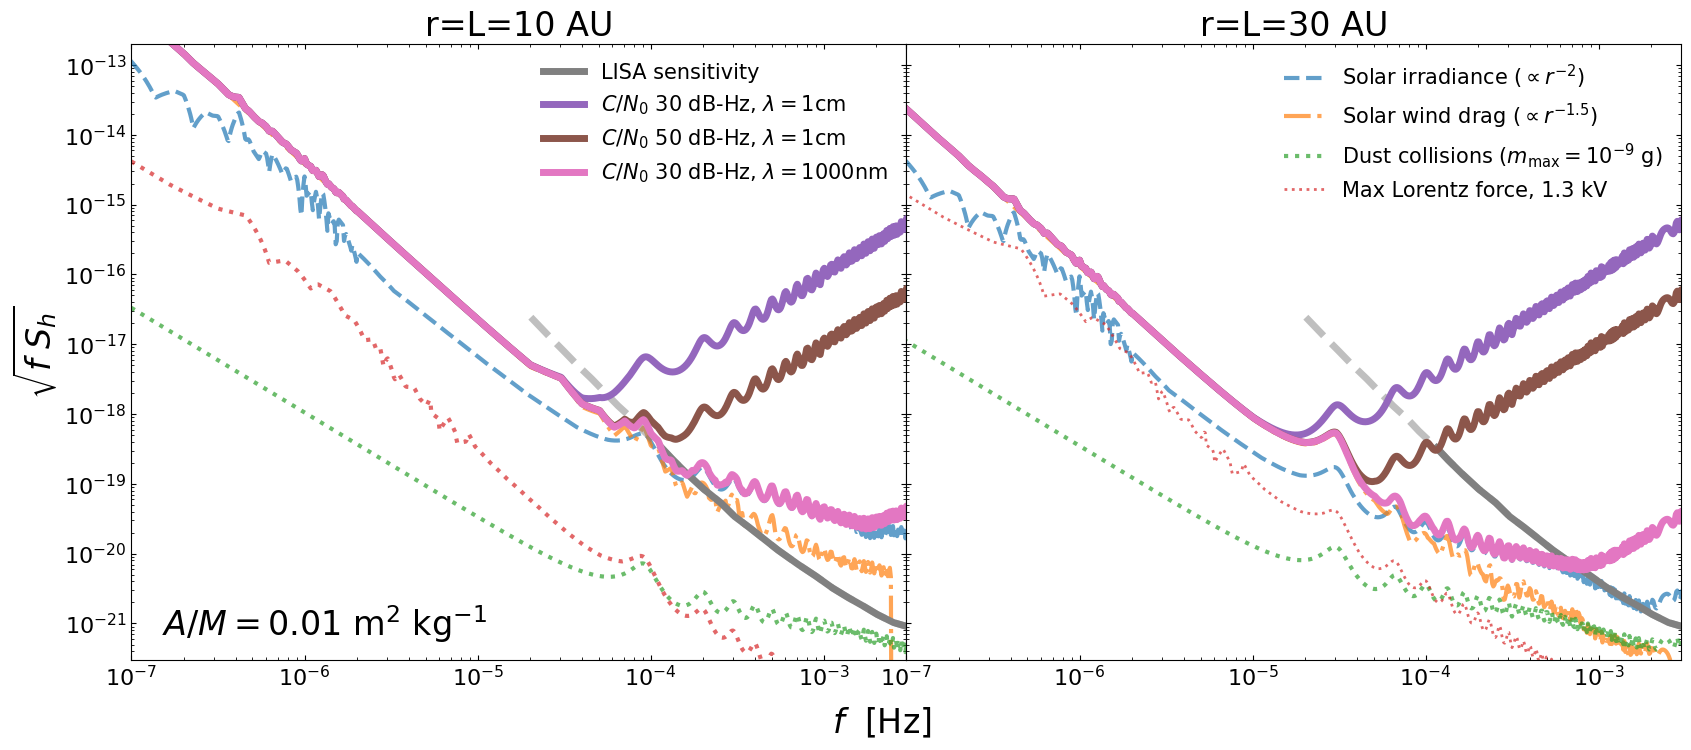

In [16]:
geometric_suppression = 0.5
show_dBHz = False
show_total = True
show_dispersion = False
only_show_acceleration_total = False

alpha_dB = 1  # opacity of laser curve
acc_width = 3 # width of lines for accelerations
             
             
# Create subplots with shared x-axis
fig, axes = plt.subplots(nrows=1, ncols=num_baselines, figsize=(10 * num_baselines, 4 * num_baselines), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0)#, top=0.95, bottom=0.05)

plt.rcParams.update({'font.size': 20})

# Loop over each baseline length
for i in range(num_baselines):
    baseline_length_AU = baseline_length_arr_AU[i]
    ax = axes[i] if num_baselines > 1 else axes

    # Extract the transfer function and compute the window function
    Romega_values = Romega_values_arr[i, :]
    window = Romega_values ** 0.5  #window applies in strain space rather to power

    # Extract the acceleration arrays for this baseline
    acc_solar_irradiance_msm2Hzmp5 = acc_solar_irradiance_msm2Hzmp5_arr[i, :]
    acceleration_drag_msm2Hzmp5 = acceleration_drag_msm2Hzmp5_arr[i, :]

    # Set the y-axis range
    acc_min = 3e-22  # Adjusted to match the strain units
    acc_max = 2e-13
    ax.set_ylim([acc_min, acc_max])

    # Calculate the noise sources for the current baseline
    noise_30dBHz = strainNoiseShotorThermal(30, lambda0, baseline_length_AU, A=radio_enhancement_beamnoise)
    noise_50dBHz = strainNoiseShotorThermal(50, lambda0, baseline_length_AU, A=radio_enhancement_beamnoise)
    noise_30dBHz_laser = strainNoiseShotorThermal(30, 10000*1e-8, baseline_length_AU)
    # You can add more noise calculations as needed

    # Calculate the acceleration noise strains for different sources
    irradiance = accelerationNoiseStrain(freq_arr, acc_solar_irradiance_msm2Hzmp5, baseline_length_AU) * geometric_suppression
    drag = accelerationNoiseStrain(freq_arr, acceleration_drag_msm2Hzmp5, baseline_length_AU) * geometric_suppression
    dust = accelerationNoiseStrain(freq_arr, acc_dust_msm2Hzmp5, baseline_length_AU)
    lorentz = accelerationNoiseStrain(freq_arr, acc_bfield_msm2Hzmp5, baseline_length_AU)

    # Plotting the acceleration noise strains
    if not only_show_acceleration_total:
        # Solar irradiance
        if i == num_baselines - 1:
            ax.loglog(freq_arr, freq_arr ** 0.5 * irradiance / window, ls='--', alpha=0.7,
                      label=r'Solar irradiance ($\propto r^{-2}$)', lw=acc_width)
        else:
            ax.loglog(freq_arr, freq_arr ** 0.5 * irradiance / window, ls='--', alpha=0.7, lw=acc_width)
            
        # Solar wind drag
        if i == num_baselines - 1:
            ax.loglog(freq_arr, freq_arr ** 0.5 * drag / window, ls='-.', alpha=0.7,
                      label=r'Solar wind drag ($\propto r^{-1.5}$)', lw=acc_width)
        else:
            ax.loglog(freq_arr, freq_arr ** 0.5 * drag / window, ls='-.', alpha=0.7, lw=acc_width)
        
        # Dust collisions
        if i == num_baselines - 1:
            ax.loglog(freq_arr, freq_arr ** 0.5 * dust / window, ls=':', alpha=0.7,
                      label=r'Dust collisions ($m_{{\rm max}} = 10^{{-{:.0f}}}$ g)'.format(-np.log10(mmax_dust)), lw=acc_width)
        else:
            ax.loglog(freq_arr, freq_arr ** 0.5 * dust / window, ls=':', alpha=0.7, lw=acc_width)
        
        # Lorentz force
        if i == num_baselines - 1:
            ax.loglog(freq_arr, freq_arr ** 0.5 * lorentz / window, ls=':', alpha=0.7,
                      label='Max Lorentz force, {:.1f} kV'.format(voltagewindeff_volts / 1e3), lw=acc_width / 1.5)
        else:
            ax.loglog(freq_arr, freq_arr ** 0.5 * lorentz / window, ls=':', alpha=0.7, lw=acc_width)

    if show_dispersion:
        if i == num_baselines - 1:
            ax.loglog(freq_arr[:-100], freq_arr[:-100]**.5*getherror_dispersion(freq_arr[:-100], baseline_length_AU, nuGHz)/window[:-100], ls='--', label='plasma noise, ' + r'$\lambda={:.0f}$cm'.format(lambda0), color='C1', lw=4)
        else:
            ax.loglog(freq_arr[:-100], freq_arr[:-100]**.5*getherror_dispersion(freq_arr[:-100], baseline_length_AU, nuGHz)/window[:-100], ls='--', color='C1', lw=4)



    # Plot LISA sensitivity
    lisa = np.genfromtxt('OSS_data_files/LISA_sensitivity_log.dat')
    lisa[:, 0] = 10 ** lisa[:, 0]
    lisa[:, 1] = 10 ** lisa[:, 1]
    ax.loglog(lisa[:, 0], lisa[:, 0] ** 0.5 * lisa[:, 1], '--', lw=acc_width + 2, color='gray', alpha=0.5)
    if i == 0:
        ax.loglog(lisa[lisa[:, 0] > 1e-4, 0], lisa[lisa[:, 0] > 1e-4, 0] ** 0.5 * lisa[lisa[:, 0] > 1e-4, 1],
                  '-', lw=acc_width + 2, color='gray', alpha=1, label='LISA sensitivity')
    else:
        ax.loglog(lisa[lisa[:, 0] > 1e-4, 0], lisa[lisa[:, 0] > 1e-4, 0] ** 0.5 * lisa[lisa[:, 0] > 1e-4, 1],
                  '-', lw=acc_width + 2, color='gray', alpha=1)

    

    # Show total noise if desired
    if show_total:
        total30dB = np.sqrt((noise_30dBHz ** 2 + irradiance ** 2 + drag ** 2) / Romega_values)
        if i == 0:
            ax.loglog(freq_arr, freq_arr ** 0.5 * total30dB, lw=acc_width + 2, alpha=1.0, color='C4',
                      label=r'$C/N_0$ 30 dB-Hz, $\lambda={:.0f}$cm'.format(lambda0))
        else:
            ax.loglog(freq_arr, freq_arr ** 0.5 * total30dB, lw=acc_width + 2, alpha=1.0, color='C4',)

        total50dB = np.sqrt((noise_50dBHz ** 2 + irradiance ** 2 + drag ** 2) / Romega_values)
        if i == 0:
            ax.loglog(freq_arr, freq_arr ** 0.5 * total50dB, lw=acc_width + 2, alpha=1.0, color='C5',
                      label=r'$C/N_0$ 50 dB-Hz, $\lambda={:.0f}$cm'.format(lambda0))
        else:
            ax.loglog(freq_arr, freq_arr ** 0.5 * total50dB, lw=acc_width + 2, alpha=1.0, color='C5',)

        #30dB Hz laser
        total30dBLaser = np.sqrt((noise_30dBHz_laser**2 + irradiance**2 + drag**2)/Romega_values)
        if i == 0:
            ax.loglog(freq_arr, freq_arr**.5*total30dBLaser, lw=acc_width+2, alpha=alpha_dB, color='C6', label=r'$C/N_0$ 30 dB-Hz, $\lambda={:.0f}$nm'.format(1000))
        else:
            ax.loglog(freq_arr, freq_arr**.5*total30dBLaser, lw=acc_width+2, alpha=alpha_dB, color='C6',)


    # Set labels and legend
    if i == 0:
        ax.set_ylabel(r'$\sqrt{f ~S_{h}}$', fontsize=24)

    # ax.legend(fontsize=15, loc='upper right', ncol=2, frameon=False, framealpha=0)
    ax.legend(fontsize=15, loc='upper right', ncol=1, frameon=False, framealpha=0)
    # if i == 0:
    #     ax.legend(fontsize=15, loc='upper right', ncol=1, frameon=False, framealpha=0)
    # else:

        
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Add text with area-to-mass ratio and baseline length
    if i == 0:
        ax.text(1.5e-7, 5e-22, r'$A/M=${:.2f} m$^2$ kg$^{{-1}}$'.format(
            area_spacecraft_irradiance_msq / mass_spacecraft_kg),
            fontsize=24, ha='left', va='bottom')
    
    # Set titles
    ax.set_title(r'r=L={} AU'.format(baseline_length_AU))
    
    # Set x and y limits
    ax.set_xlim([1e-7, .003])
    if show_dispersion:
        ax.set_xlim([1e-7, .002])

    ax.set_ylim([acc_min, acc_max])

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', top=True, direction='in')
    ax.tick_params(axis='y', right=True, direction='in')
    ax.tick_params(axis='both', which='minor', direction='in')
    ax.tick_params(axis='x', which='minor', top=True)
    ax.tick_params(axis='y', which='minor', right=True)


fig.supxlabel(r'$f$  [Hz]', fontsize=24)#, y=-0.01)


# Adjust layout and show the plot

# Optionally, save the figure
# if show_dispersion:
#     plt.savefig("figures/strainsensitivity_A{}m{}_dispersion.pdf".format(area_spacecraft_irradiance_msq, mass_spacecraft_kg), format='pdf')
# else:
#     plt.savefig("figures/strainsensitivity_A{}m{}.pdf".format(area_spacecraft_irradiance_msq, mass_spacecraft_kg), format='pdf')

# plt.savefig("/Users/cdmcgrat/Desktop/matt_updated_figs/fig6.pdf", bbox_inches='tight', format='pdf')

plt.show()


## Let's now show total sensitivity with respect to different parameters

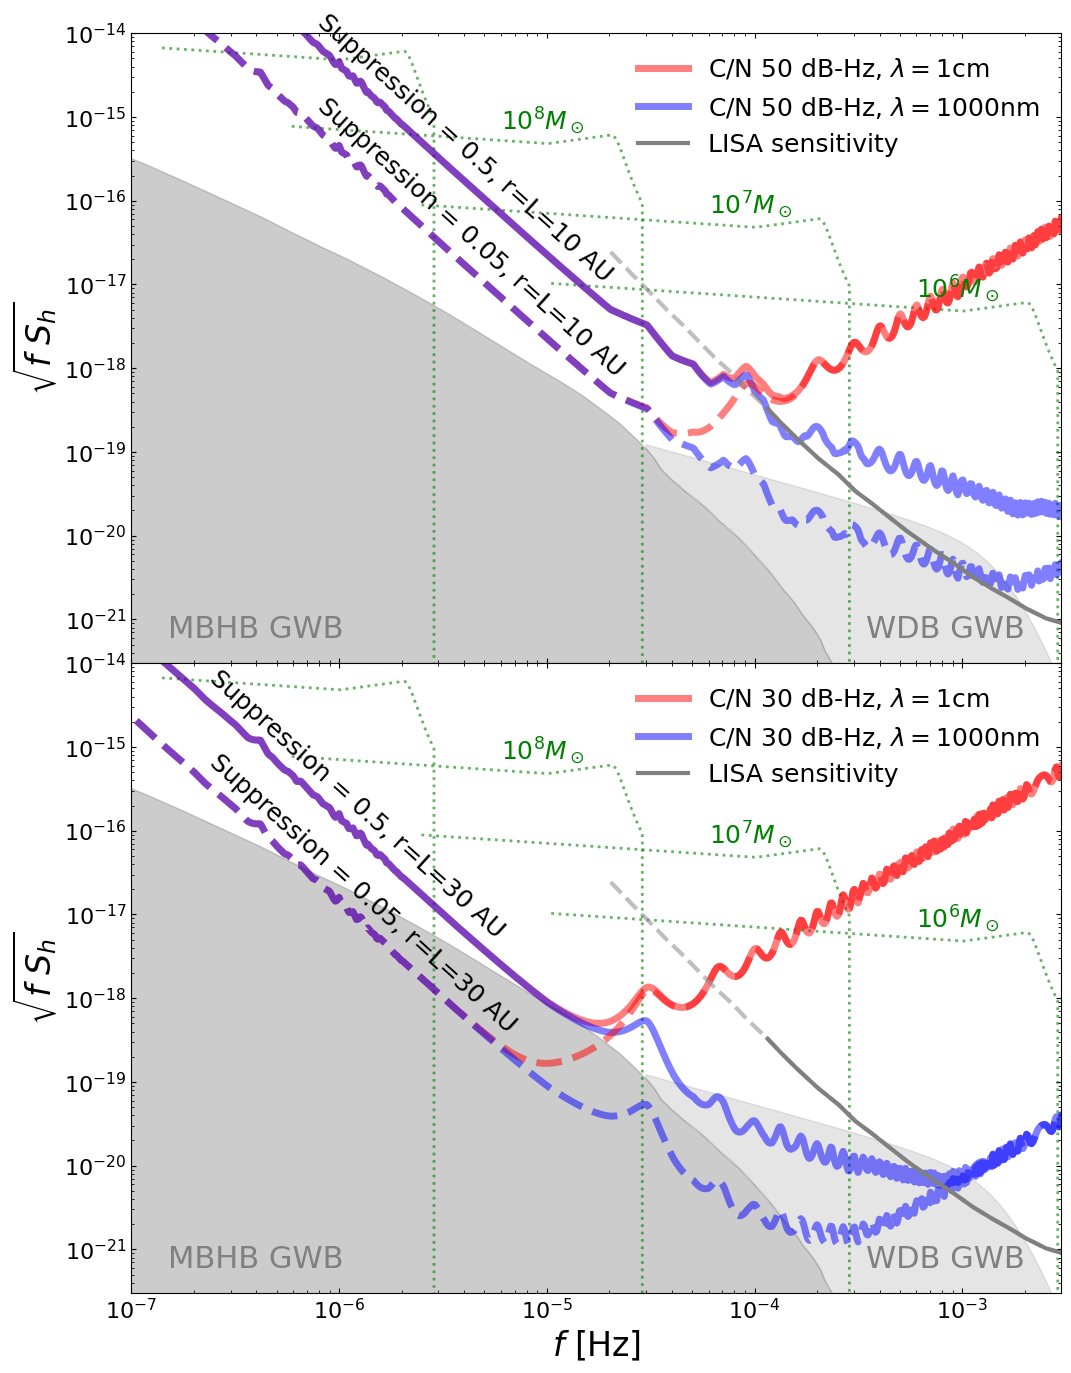

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables are already defined:
# - baseline_length_arr_AU: array of baseline lengths in AU
# - freq_arr: array of frequencies
# - Romega_values_arr: array of transfer functions for each baseline
# - acc_solar_irradiance_msm2Hzmp5_arr
# - acceleration_drag_msm2Hzmp5_arr
# - acc_dust_msm2Hzmp5_arr
# - acc_dust_msm2Hzmp5_2_arr
# - acc_bfield_msm2Hzmp5_arr
# - mmax_dust, mmax_dust2
# - area_spacecraft_irradiance_msq, mass_spacecraft_kg
# - voltagewindeff_volts
# - geometric_suppression
# - 'nuMBHs', 'characteristic_strain_MBHs' for MBH binaries

# Number of baselines
num_baselines = len(baseline_length_arr_AU)

# Plot settings
plt.rc('font', size=18)
acc_width = 3  # width of lines for accelerations

#min frequency and min y value (strain)
fminplot = 1e-7
yminplot = 3e-22

fminval_sup = [.5e-6, .15e-6]
dBHz = [50, 30]


# Create subplots with shared x-axis
fig, axes = plt.subplots(nrows=num_baselines, ncols=1, figsize=(12, 7 * num_baselines), sharex=True)
plt.subplots_adjust(hspace=0, top=0.95, bottom=0.05)

# Loop over each baseline length
for i in range(num_baselines):

    baseline_length_AU = baseline_length_arr_AU[i]
    ax = axes[i] if num_baselines > 1 else axes

    # Extract the transfer function and compute the window function
    Romega_values = Romega_values_arr[i, :]
    window = Romega_values ** 0.5

    # Extract the acceleration arrays for this baseline
    acc_solar_irradiance_msm2Hzmp5 = acc_solar_irradiance_msm2Hzmp5_arr[i, :]
    acceleration_drag_msm2Hzmp5 = acceleration_drag_msm2Hzmp5_arr[i, :]
    #acc_dust_msm2Hzmp5 = acc_dust_msm2Hzmp5_arr[i, :]
    #acc_bfield_msm2Hzmp5 = acc_bfield_msm2Hzmp5_arr[i, :]

    # Calculate the noise sources for the current baseline
    #noise_30dBHz = strainNoiseShotorThermal(30, lambda0, baseline_length_AU, A=radio_enhancement_beamnoise)
    #noise_30dBHz_laser = strainNoiseShotorThermal(30, 10000 * 1e-8, baseline_length_AU)

    # Calculate the acceleration noise strains for different sources
    #irradiance = accelerationNoiseStrain(freq_arr, acc_solar_irradiance_msm2Hzmp5, baseline_length_AU) * geometric_suppression
    #drag = accelerationNoiseStrain(freq_arr, acceleration_drag_msm2Hzmp5, baseline_length_AU) * geometric_suppression
    #dust = accelerationNoiseStrain(freq_arr, acc_dust_msm2Hzmp5, baseline_length_AU)
  
    # Plot gravitational wave backgrounds
    freq_arr_reduced = freq_arr[freq_arr > 3e-5]
    characteristic_strain_MBHs_newrange = np.interp(freq_arr_reduced, nuMBHs, characteristic_strain_MBHs)
    characteristic_strain_MBHs_newrange[freq_arr_reduced < nuMBHs[0]] = 0
    characteristic_strain_MBHs_newrange[freq_arr_reduced > nuMBHs[-1]] = 0

    ax.fill_between(freq_arr_reduced, characteristic_strain_MBHs_newrange,
                    y2=freq_arr_reduced ** 0.5 * hnubinariesCornish(freq_arr_reduced), color='gray', alpha=0.2)
    ax.fill_between(nuMBHs, np.zeros_like(characteristic_strain_MBHs), y2=characteristic_strain_MBHs, color='gray', alpha=0.4)
    ax.text(fminplot * 1.5, yminplot * 2, "MBHB GWB", color='gray', alpha=1, fontsize=22, ha='left', rotation=0)
    ax.text(2e-3, yminplot * 2, "WDB GWB", color='gray', alpha=1, fontsize=22, ha='right', rotation=0)

    # Include signals if desired
    include_signals = True
    if include_signals:
        for massBH in [1e6, 1e7, 1e8, 1e9]:
            strainMBH = np.array([characteristicStrainMBH(nuGW, massBH, massBH) for nuGW in freq_arr])
            yearsbefore = 5
            minf = frequencyMB(massBH, massBH, yearsbefore)
            minf2 = frequencyMB(massBH, massBH, .01*massBH/1e8)
            ax.loglog(freq_arr[freq_arr > minf], strainMBH[freq_arr > minf], ':g', lw=2, alpha=0.6)

            if massBH < 3e8:
                reduced_f = freq_arr[freq_arr > minf]
                reduced_strain = strainMBH[freq_arr > minf]

                idx_rs = np.argmin(np.abs(reduced_f - minf2))
                ax.text(minf2, 1.1*reduced_strain[idx_rs],
                        r'$10^{:.0f}M_\odot$'.format(np.log10(massBH)), color='green', ha='left', va='bottom')

    # Define a linestyle for each geometric suppression
    linestyle_dict = {0.5: '-', 0.05: '--'}

    # Define a color for each set of curves
    color_dict = {'radio': 'red', 'laser': 'blue'}

    for geometric_suppression_iter in [0.5, 0.05]:
        if geometric_suppression_iter == 0.5:
            label1 = 'C/N {} dB-Hz, $\lambda={:.0f}$cm'.format(dBHz[i], lambda0)
            label2 = 'C/N {} dB-Hz, $\lambda={:.0f}$nm'.format(dBHz[i], 1000)
        else:
            label1 = ''
            label2 = ''

        # Recalculate acceleration noise strains with current suppression
        irradiance_iter = accelerationNoiseStrain(freq_arr, acc_solar_irradiance_msm2Hzmp5, baseline_length_AU) * geometric_suppression_iter
        drag_iter = accelerationNoiseStrain(freq_arr, acceleration_drag_msm2Hzmp5, baseline_length_AU) * geometric_suppression_iter
        noise_dBHz = strainNoiseShotorThermal(dBHz[i], lambda0, baseline_length_AU, A=radio_enhancement_beamnoise)
        noise_dBHz_laser = strainNoiseShotorThermal(dBHz[i], 10000*1e-8, baseline_length_AU)

        # Total noise
        totaldB = np.sqrt((noise_dBHz ** 2 + irradiance_iter ** 2 + drag_iter ** 2) / Romega_values)
        ax.loglog(freq_arr, freq_arr ** 0.5 * totaldB, lw=5, alpha=0.5, color=color_dict['radio'],
                  linestyle=linestyle_dict[geometric_suppression_iter], label=label1)

        # Annotate suppression level
        idx_fminplot = np.argmin(np.abs(freq_arr - fminval_sup[i]))
        ax.text(fminval_sup[i] * 1.5, freq_arr[idx_fminplot] ** 0.5 * totaldB[idx_fminplot],
                'Suppression = {}, r=L={} AU'.format(geometric_suppression_iter,baseline_length_AU), color='k', ha='left', va='top', rotation=-42)

        # Total noise for laser wavelength
        totaldB_laser = np.sqrt((noise_dBHz_laser ** 2 + irradiance_iter ** 2 + drag_iter ** 2) / Romega_values)
        ax.loglog(freq_arr, freq_arr ** 0.5 * totaldB_laser, lw=5, alpha=0.5, color=color_dict['laser'],
                  linestyle=linestyle_dict[geometric_suppression_iter], label=label2)

    # Plot LISA sensitivity
    lisa = np.genfromtxt('OSS_data_files/LISA_sensitivity_log.dat')
    lisa[:, 0] = 10 ** lisa[:, 0]
    lisa[:, 1] = 10 ** lisa[:, 1]
    ax.loglog(lisa[:, 0], lisa[:, 0] ** 0.5 * lisa[:, 1], '--', lw=3, color='gray', alpha=0.5)
    ax.loglog(lisa[lisa[:, 0] > 1e-4, 0], lisa[lisa[:, 0] > 1e-4, 0] ** 0.5 * lisa[lisa[:, 0] > 1e-4, 1],
              '-', lw=3, color='gray', alpha=1, label='LISA sensitivity')

    # Set labels and legend
    if i == num_baselines - 1:
        ax.set_xlabel(r'$f$ [Hz]', fontsize=24)

    ax.set_ylabel(r'$\sqrt{f ~S_{h}}$', fontsize=24)
    ax.legend(fontsize=18, loc='upper right', frameon=False, framealpha=0)
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Set x and y limits
    ax.set_xlim([1e-7, .003])
    ax.set_ylim([yminplot, 1e-14])

    # Add text with baseline length and suppression level
    #ax.text(1.5e-7, yminplot * 1.5, r'r=L={} AU'.format(baseline_length_AU),
    #        fontsize=22, ha='left', va='bottom')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', top=True, direction='in')
    ax.tick_params(axis='y', right=True, direction='in')
    ax.tick_params(axis='both', which='minor', direction='in')
    ax.tick_params(axis='x', which='minor', top=True)
    ax.tick_params(axis='y', which='minor', right=True)

# Optionally, save the figure
# plt.savefig("figures/strainsensitivity_justtotals_A{}m{}.pdf".format(area_spacecraft_irradiance_msq, mass_spacecraft_kg), format='pdf')

plt.show()


## plot 3 v2

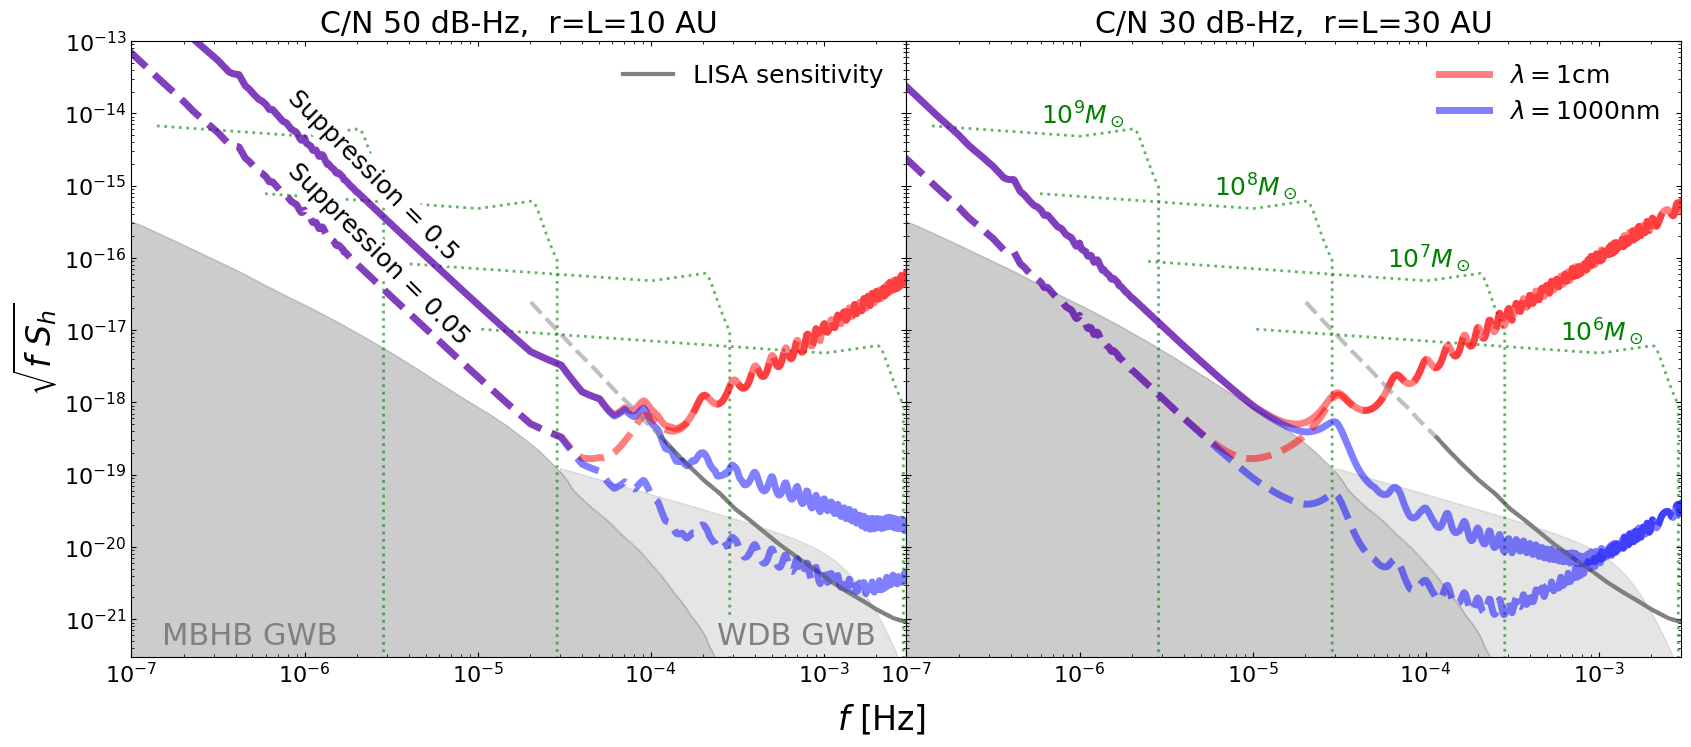

In [18]:
# Assuming the following variables are already defined:
# - baseline_length_arr_AU: array of baseline lengths in AU
# - freq_arr: array of frequencies
# - Romega_values_arr: array of transfer functions for each baseline
# - acc_solar_irradiance_msm2Hzmp5_arr
# - acceleration_drag_msm2Hzmp5_arr
# - acc_dust_msm2Hzmp5_arr
# - acc_dust_msm2Hzmp5_2_arr
# - acc_bfield_msm2Hzmp5_arr
# - mmax_dust, mmax_dust2
# - area_spacecraft_irradiance_msq, mass_spacecraft_kg
# - voltagewindeff_volts
# - geometric_suppression
# - 'nuMBHs', 'characteristic_strain_MBHs' for MBH binaries

# Number of baselines
num_baselines = len(baseline_length_arr_AU)

# Plot settings
plt.rc('font', size=18)
acc_width = 3  # width of lines for accelerations

#min frequency and min y value (strain)
fminplot = 1e-7
yminplot = 3e-22

fminval_sup = [.5e-6, .15e-6]
dBHz = [50, 30]


# Create subplots with shared x-axis
fig, axes = plt.subplots(nrows=1, ncols=num_baselines, figsize=(10 * num_baselines, 4 * num_baselines), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0)#, top=0.95, bottom=0.05)


# Loop over each baseline length
for i in range(num_baselines):

    baseline_length_AU = baseline_length_arr_AU[i]
    ax = axes[i] if num_baselines > 1 else axes

    # Extract the transfer function and compute the window function
    Romega_values = Romega_values_arr[i, :]
    window = Romega_values ** 0.5

    # Extract the acceleration arrays for this baseline
    acc_solar_irradiance_msm2Hzmp5 = acc_solar_irradiance_msm2Hzmp5_arr[i, :]
    acceleration_drag_msm2Hzmp5 = acceleration_drag_msm2Hzmp5_arr[i, :]

  
    # Plot gravitational wave backgrounds
    freq_arr_reduced = freq_arr[freq_arr > 3e-5]
    characteristic_strain_MBHs_newrange = np.interp(freq_arr_reduced, nuMBHs, characteristic_strain_MBHs)
    characteristic_strain_MBHs_newrange[freq_arr_reduced < nuMBHs[0]] = 0
    characteristic_strain_MBHs_newrange[freq_arr_reduced > nuMBHs[-1]] = 0

    ax.fill_between(freq_arr_reduced, characteristic_strain_MBHs_newrange,
                    y2=freq_arr_reduced ** 0.5 * hnubinariesCornish(freq_arr_reduced), color='gray', alpha=0.2)
    ax.fill_between(nuMBHs, np.zeros_like(characteristic_strain_MBHs), y2=characteristic_strain_MBHs, color='gray', alpha=0.4)
    
    if i == 0:
        ax.text(fminplot * 1.5, yminplot * 1.5, "MBHB GWB", color='gray', alpha=1, fontsize=22, ha='left', rotation=0)
        ax.text(2e-3, yminplot * 1.5, "WDB GWB", color='gray', alpha=1, fontsize=22, ha='right', rotation=0, bbox=dict(boxstyle='square,pad=0.1',alpha=1,color='#e6e6e6'))

    # Include signals if desired
    include_signals = True
    if include_signals:
        for massBH in [1e6, 1e7, 1e8, 1e9]:
            strainMBH = np.array([characteristicStrainMBH(nuGW, massBH, massBH) for nuGW in freq_arr])
            yearsbefore = 5
            minf = frequencyMB(massBH, massBH, yearsbefore)
            minf2 = frequencyMB(massBH, massBH, .01*massBH/1e8)
            ax.loglog(freq_arr[freq_arr > minf], strainMBH[freq_arr > minf], ':g', lw=2, alpha=0.6)

            if massBH < 3e9:
                reduced_f = freq_arr[freq_arr > minf]
                reduced_strain = strainMBH[freq_arr > minf]

                idx_rs = np.argmin(np.abs(reduced_f - minf2))
                if i == num_baselines - 1:
                    ax.text(minf2, 1.1*reduced_strain[idx_rs],
                            r'$10^{:.0f}M_\odot$'.format(np.log10(massBH)), color='green', ha='left', va='bottom')

    # Define a linestyle for each geometric suppression
    linestyle_dict = {0.5: '-', 0.05: '--'}

    # Define a color for each set of curves
    color_dict = {'radio': 'red', 'laser': 'blue'}

    for geometric_suppression_iter in [0.5, 0.05]:
        if geometric_suppression_iter == 0.5:
            label1 = '$\lambda={:.0f}$cm'.format(lambda0)
            label2 = '$\lambda={:.0f}$nm'.format(1000)
        else:
            label1 = ''
            label2 = ''

        # Recalculate acceleration noise strains with current suppression
        irradiance_iter = accelerationNoiseStrain(freq_arr, acc_solar_irradiance_msm2Hzmp5, baseline_length_AU) * geometric_suppression_iter
        drag_iter = accelerationNoiseStrain(freq_arr, acceleration_drag_msm2Hzmp5, baseline_length_AU) * geometric_suppression_iter
        noise_dBHz = strainNoiseShotorThermal(dBHz[i], lambda0, baseline_length_AU, A=radio_enhancement_beamnoise)
        noise_dBHz_laser = strainNoiseShotorThermal(dBHz[i], 10000*1e-8, baseline_length_AU)

        # Total noise
        totaldB = np.sqrt((noise_dBHz ** 2 + irradiance_iter ** 2 + drag_iter ** 2) / Romega_values)
        if i == num_baselines - 1:
            ax.loglog(freq_arr, freq_arr ** 0.5 * totaldB, lw=5, alpha=0.5, color=color_dict['radio'],
                      linestyle=linestyle_dict[geometric_suppression_iter], label=label1)
        else:
            ax.loglog(freq_arr, freq_arr ** 0.5 * totaldB, lw=5, alpha=0.5, color=color_dict['radio'],
                      linestyle=linestyle_dict[geometric_suppression_iter])

        # Annotate suppression level
        idx_fminplot = np.argmin(np.abs(freq_arr - fminval_sup[i]))
        if i == 0:
            ax.text(fminval_sup[i] * 1.5, 1.25*freq_arr[idx_fminplot] ** 0.5 * totaldB[idx_fminplot],
                    'Suppression = {}'.format(geometric_suppression_iter), color='k', ha='left', va='top', rotation=-45, bbox=dict(boxstyle='square,pad=0.05',alpha=1,color='white'))

        # Total noise for laser wavelength
        totaldB_laser = np.sqrt((noise_dBHz_laser ** 2 + irradiance_iter ** 2 + drag_iter ** 2) / Romega_values)
        if i == num_baselines - 1:
            ax.loglog(freq_arr, freq_arr ** 0.5 * totaldB_laser, lw=5, alpha=0.5, color=color_dict['laser'],
                      linestyle=linestyle_dict[geometric_suppression_iter], label=label2)
        else:
            ax.loglog(freq_arr, freq_arr ** 0.5 * totaldB_laser, lw=5, alpha=0.5, color=color_dict['laser'],
                      linestyle=linestyle_dict[geometric_suppression_iter])


        ax.set_title(r'C/N {} dB-Hz,  r=L={} AU'.format(dBHz[i], baseline_length_AU))


    # Plot LISA sensitivity
    lisa = np.genfromtxt('OSS_data_files/LISA_sensitivity_log.dat')
    lisa[:, 0] = 10 ** lisa[:, 0]
    lisa[:, 1] = 10 ** lisa[:, 1]
    ax.loglog(lisa[:, 0], lisa[:, 0] ** 0.5 * lisa[:, 1], '--', lw=3, color='gray', alpha=0.5)
    if i == 0:
        ax.loglog(lisa[lisa[:, 0] > 1e-4, 0], lisa[lisa[:, 0] > 1e-4, 0] ** 0.5 * lisa[lisa[:, 0] > 1e-4, 1],
                  '-', lw=3, color='gray', alpha=1, zorder=0, label='LISA sensitivity')
    else:
        ax.loglog(lisa[lisa[:, 0] > 1e-4, 0], lisa[lisa[:, 0] > 1e-4, 0] ** 0.5 * lisa[lisa[:, 0] > 1e-4, 1],
                  '-', lw=3, color='gray', alpha=1, zorder=0)

    # Set labels and legend
    # ax.set_title(r'r=L={} AU'.format(baseline_length_AU))

    if i == 0:
        ax.set_ylabel(r'$\sqrt{f ~S_{h}}$', fontsize=24)
    ax.legend(fontsize=18, loc='upper right', frameon=False, framealpha=0)
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Set x and y limits
    ax.set_xlim([1e-7, .003])
    ax.set_ylim([yminplot, 1e-13])

    # Add text with baseline length and suppression level
    #ax.text(1.5e-7, yminplot * 1.5, r'r=L={} AU'.format(baseline_length_AU),
    #        fontsize=22, ha='left', va='bottom')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', top=True, direction='in')
    ax.tick_params(axis='y', right=True, direction='in')
    ax.tick_params(axis='both', which='minor', direction='in')
    ax.tick_params(axis='x', which='minor', top=True)
    ax.tick_params(axis='y', which='minor', right=True)

fig.supxlabel(r'$f$ [Hz]', fontsize=24)


# Optionally, save the figure
# plt.savefig("figures/strainsensitivity_justtotals_A{}m{}.pdf".format(area_spacecraft_irradiance_msq, mass_spacecraft_kg), format='pdf')

# plt.savefig("/Users/cdmcgrat/Desktop/matt_updated_figs/fig3.pdf", bbox_inches='tight', format='pdf')

plt.show()


#  single arm great clock

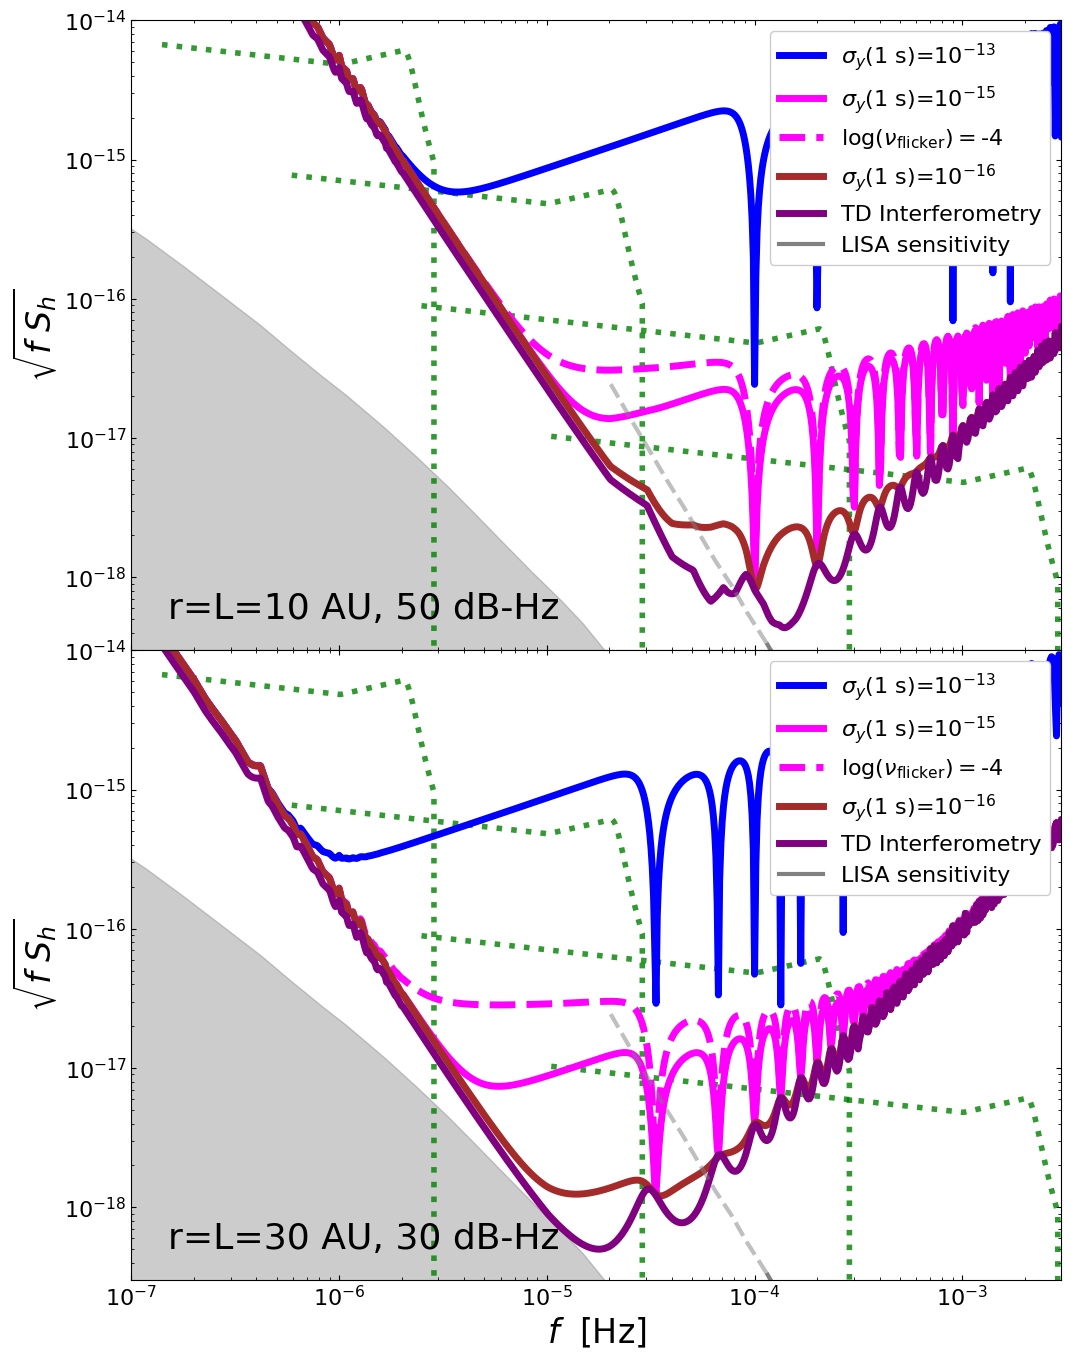

In [19]:
FOR_NIAC = False  # I altered this plot for NIAC poster/presentation

# Number of baselines
num_baselines = len(baseline_length_arr_AU)

# Create subplots with shared x-axis
fig, axes = plt.subplots(nrows=num_baselines, ncols=1, figsize=(12, 7 * num_baselines), sharex=True)
plt.subplots_adjust(hspace=0, top=0.95, bottom=0.05)
plt.rc('font', size=18)

fminplot = 1e-7
yminplot = 3e-19
geometric_suppression = 0.5

# Loop over each baseline length
for idx in range(num_baselines):
    baseline_length_AU = baseline_length_arr_AU[idx]
    ax = axes[idx] if num_baselines > 1 else axes

    # Extract the transfer function and compute the window function
    Romega_values = Romega_values_arr[idx, :]  #two arm 
    Romega_values_singlearm = Romega_values_singlearm_arr[idx, :] #single arm

    # Extract the acceleration arrays for this baseline
    acc_solar_irradiance_msm2Hzmp5 = acc_solar_irradiance_msm2Hzmp5_arr[idx, :]
    acceleration_drag_msm2Hzmp5 = acceleration_drag_msm2Hzmp5_arr[idx, :]
    #acc_dust_msm2Hzmp5 = acc_dust_msm2Hzmp5_arr[idx, :]
    #acc_bfield_msm2Hzmp5 = acc_bfield_msm2Hzmp5_arr[idx, :]

    # Calculate the noise sources for the current baseline
    noise_dBHz = strainNoiseShotorThermal(dBHz[idx], lambda0, baseline_length_AU, A=radio_enhancement_beamnoise)
    noise_dBHz_laser = strainNoiseShotorThermal(dBHz[idx], 10000 * 1e-8, baseline_length_AU)

    # Prepare to plot MBHB GWB and WDB GWB
    freq_arr_reduced = freq_arr[freq_arr > 3e-5]
    characteristic_strain_MBHs_newrange = np.interp(freq_arr_reduced, nuMBHs, characteristic_strain_MBHs)
    characteristic_strain_MBHs_newrange[freq_arr_reduced < nuMBHs[0]] = 0
    characteristic_strain_MBHs_newrange[freq_arr_reduced > nuMBHs[-1]] = 0

    ax.fill_between(freq_arr_reduced, characteristic_strain_MBHs_newrange,
                    y2=freq_arr_reduced ** 0.5 * hnubinariesCornish(freq_arr_reduced),
                    color='gray', alpha=0.2)
    ax.fill_between(nuMBHs, np.zeros_like(characteristic_strain_MBHs), y2=characteristic_strain_MBHs,
                    color='gray', alpha=0.4)
    #ax.text(fminplot * 1.5, yminplot * 2, "MBHB GWB", color='gray', alpha=1, fontsize=22, ha='left', rotation=0)
    #ax.text(2e-3, yminplot * 2, "WDB GWB", color='gray', alpha=1, fontsize=22, ha='right', rotation=0)

    # Include signals
    include_signals = True
    if include_signals:
        for massBH in [1e6, 1e7, 1e8, 1e9]:
            strainMBH = np.array([characteristicStrainMBH(nuGW, massBH, massBH) for nuGW in freq_arr])
            yearsbefore = 5
            minf = frequencyMB(massBH, massBH, yearsbefore)
            ax.loglog(freq_arr[freq_arr > minf], strainMBH[freq_arr > minf], ':g', lw=4, alpha=0.8)

            if massBH < 3e8:
                reduced_f = freq_arr[freq_arr > minf]
                reduced_strain = strainMBH[freq_arr > minf]
                #ax.text(minf * 1.2, 1.1 * reduced_strain[0],
                #        r'$10^{:.0f}M_\odot$'.format(np.log10(massBH)),
                #        color='green', ha='left', va='bottom')

    # Define a linestyle for each geometric suppression
    linestyle_dict = {0.5: '-', 0.05: '--'}

    # Define a color array for plotting
    color_array = ['blue', 'magenta', 'brown', 'purple']
    i_color = 0

    # Function to calculate clock noise power
    def clocknoise_power(allan_deviation, nuGW, baseline_length_AU, nu_flicker=0):
        taubaseline = baseline_length_AU * AU_in_cm / lightspeed
        x = 2 * np.pi * nuGW * taubaseline
        return 2 * allan_deviation ** 2 * (1 - np.cos(2 * x)) / x ** 2 * (1 + nu_flicker / nuGW)

    totaldB_clockdict = {}
    for allan_deviation in [1e-13, 1e-15, 1e-16]:
        irradiance = accelerationNoiseStrain(freq_arr, acc_solar_irradiance_msm2Hzmp5, baseline_length_AU) * geometric_suppression
        drag = accelerationNoiseStrain(freq_arr, acceleration_drag_msm2Hzmp5, baseline_length_AU) * geometric_suppression

        # Calculate clock noise power
        clock_noise_power = clocknoise_power(allan_deviation, freq_arr, baseline_length_AU)

        # Total noise
        totaldB_clockdict[allan_deviation] = np.sqrt(
            (noise_dBHz ** 2 + irradiance ** 2 + drag ** 2 + clock_noise_power) / Romega_values_singlearm)

        exponent = int(np.floor(np.log10(allan_deviation)))
        label = r'$\sigma_y$(1 s)=' + r'$10^{{{}}}$'.format(exponent)

        ax.loglog(freq_arr, freq_arr ** 0.5 * totaldB_clockdict[allan_deviation],
                  lw=5, alpha=1, color=color_array[i_color], label=label)

        if allan_deviation < 1e-16 and not FOR_NIAC:
            clock_noise_power_laser = clocknoise_power(allan_deviation, freq_arr, baseline_length_AU)
            totaldB_laser = np.sqrt(
                (noise_dBHz_laser ** 2 + irradiance ** 2 + drag ** 2 + clock_noise_power_laser) / Romega_values_singlearm)
            ax.loglog(freq_arr, freq_arr ** 0.5 * totaldB_laser, lw=5, alpha=0.5, color=color_array[i_color],
                      linestyle='--', label='')
            ax.text(2e-3, 1.8e-18, r'Lasers, $\sigma_y =${}'.format(allan_deviation),
                    color=color_array[i_color], ha='right', va='top', rotation=12)

        if allan_deviation == 1e-15 and not FOR_NIAC:
            for nu_flicker in [1e-4]:
                clock_noise_power_flicker = clocknoise_power(
                    allan_deviation, freq_arr, baseline_length_AU, nu_flicker=nu_flicker)
                totaldB_withflicker = np.sqrt(
                    (noise_dBHz ** 2 + irradiance ** 2 + drag ** 2 + clock_noise_power_flicker) / Romega_values_singlearm)
                ax.loglog(freq_arr, freq_arr ** 0.5 * totaldB_withflicker, ls='--', lw=5, alpha=1,
                          color=color_array[i_color],
                          label=r'$\log(\nu_{{\rm flicker}})=$' + '{:.0f}'.format(np.log10(nu_flicker)))

        i_color += 1

    if True:
        totaldB = np.sqrt((noise_dBHz ** 2 + irradiance ** 2 + drag ** 2) / Romega_values)
        ax.loglog(freq_arr, freq_arr ** 0.5 * totaldB, lw=5, alpha=1, color=color_array[i_color],
                  label=r'TD Interferometry')

    # Plot LISA sensitivity
    lisa = np.genfromtxt('OSS_data_files/LISA_sensitivity_log.dat')
    lisa[:, 0] = 10 ** lisa[:, 0]
    lisa[:, 1] = 10 ** lisa[:, 1]
    ax.loglog(lisa[:, 0], lisa[:, 0] ** 0.5 * lisa[:, 1], '--', lw=3, color='gray', alpha=0.5)
    ax.loglog(lisa[lisa[:, 0] > 1e-4, 0], lisa[lisa[:, 0] > 1e-4, 0] ** 0.5 * lisa[lisa[:, 0] > 1e-4, 1],
              '-', lw=3, color='gray', alpha=1, label='LISA sensitivity')

    # Set labels and legend
    if idx == num_baselines - 1:
        if FOR_NIAC:
            ax.set_xlabel(r'Gravitational Wave frequency [Hz]', fontsize=20)
        else:
            ax.set_xlabel(r'$f$  [Hz]', fontsize=24)

    ax.set_ylabel(r'$\sqrt{f~S_{h}}$', fontsize=24)
    ax.legend(fontsize=16, loc='upper right', framealpha=1)
    ax.tick_params(axis='both', which='major', labelsize=16)

    # Set x and y limits
    ax.set_xlim([fminplot, .003])
    ax.set_ylim([yminplot, 1e-14])

    # Add text with baseline length
    ax.text(fminplot * 1.5, yminplot * 1.5, r'r=L={} AU, {} dB-Hz'.format(baseline_length_AU, dBHz[idx]),
            fontsize=26, ha='left', va='bottom')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', top=True, direction='in')
    ax.tick_params(axis='y', right=True, direction='in')
    ax.tick_params(axis='both', which='minor', direction='in')
    ax.tick_params(axis='x', which='minor', top=True)
    ax.tick_params(axis='y', which='minor', right=True)

# Adjust layout

# Optionally, save the figure
# plt.savefig("figures/strainsensitivity_clock_A{}m{}.pdf".format(area_spacecraft_irradiance_msq, mass_spacecraft_kg), format='pdf')

plt.show()


## plot 4 v2

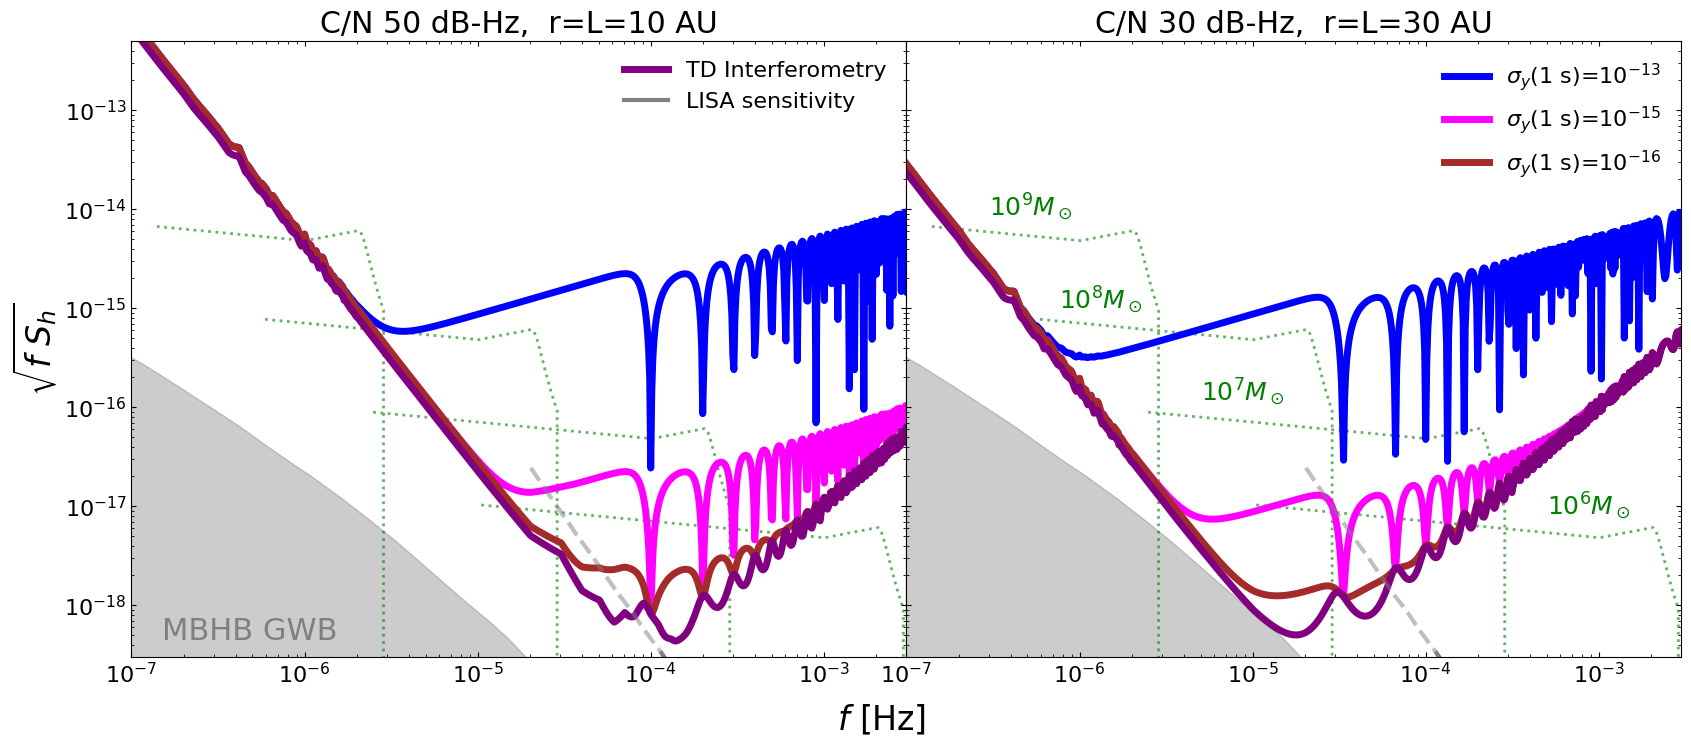

In [20]:
FOR_NIAC = False  # I altered this plot for NIAC poster/presentation

# Number of baselines
num_baselines = len(baseline_length_arr_AU)

# Create subplots with shared x-axis
fig, axes = plt.subplots(nrows=1, ncols=num_baselines, figsize=(10 * num_baselines, 4 * num_baselines), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0)
plt.rc('font', size=18)

fminplot = 1e-7
yminplot = 3e-19
geometric_suppression = 0.5

# Loop over each baseline length
for idx in range(num_baselines):
    baseline_length_AU = baseline_length_arr_AU[idx]
    ax = axes[idx] if num_baselines > 1 else axes

    # Extract the transfer function and compute the window function
    Romega_values = Romega_values_arr[idx, :]  #two arm 
    Romega_values_singlearm = Romega_values_singlearm_arr[idx, :] #single arm

    # Extract the acceleration arrays for this baseline
    acc_solar_irradiance_msm2Hzmp5 = acc_solar_irradiance_msm2Hzmp5_arr[idx, :]
    acceleration_drag_msm2Hzmp5 = acceleration_drag_msm2Hzmp5_arr[idx, :]

    # Calculate the noise sources for the current baseline
    noise_dBHz = strainNoiseShotorThermal(dBHz[idx], lambda0, baseline_length_AU, A=radio_enhancement_beamnoise)
    noise_dBHz_laser = strainNoiseShotorThermal(dBHz[idx], 10000 * 1e-8, baseline_length_AU)

    # Prepare to plot MBHB GWB and WDB GWB
    freq_arr_reduced = freq_arr[freq_arr > 3e-5]
    characteristic_strain_MBHs_newrange = np.interp(freq_arr_reduced, nuMBHs, characteristic_strain_MBHs)
    characteristic_strain_MBHs_newrange[freq_arr_reduced < nuMBHs[0]] = 0
    characteristic_strain_MBHs_newrange[freq_arr_reduced > nuMBHs[-1]] = 0

    ax.fill_between(freq_arr_reduced, characteristic_strain_MBHs_newrange,
                    y2=freq_arr_reduced ** 0.5 * hnubinariesCornish(freq_arr_reduced),
                    color='gray', alpha=0.2)
    ax.fill_between(nuMBHs, np.zeros_like(characteristic_strain_MBHs), y2=characteristic_strain_MBHs,
                    color='gray', alpha=0.4)
    
    if idx == 0:
        ax.text(fminplot * 1.5, yminplot * 1.5, "MBHB GWB", color='gray', alpha=1, fontsize=22, ha='left', rotation=0)

    # Include signals
    include_signals = True
    if include_signals:
        for j, massBH in enumerate([1e6, 1e7, 1e8, 1e9]):
            strainMBH = np.array([characteristicStrainMBH(nuGW, massBH, massBH) for nuGW in freq_arr])
            yearsbefore = 5
            minf = frequencyMB(massBH, massBH, yearsbefore)
            ax.loglog(freq_arr[freq_arr > minf], strainMBH[freq_arr > minf], ':g', lw=2, alpha=0.6)

            if massBH < 3e9:
                reduced_f = freq_arr[freq_arr > minf]
                reduced_strain = strainMBH[freq_arr > minf]

                text_x_positions = [5e-4,  5e-6,                    minf * 1.3,              3e-7]
                text_y_positions = [7e-18, 1.1 * reduced_strain[0], 1.1 * reduced_strain[0], 1.1 * reduced_strain[0]]
                if idx == num_baselines - 1:
                    ax.text(text_x_positions[j], text_y_positions[j],
                           r'$10^{:.0f}M_\odot$'.format(np.log10(massBH)),
                           color='green', ha='left', va='bottom', bbox=dict(boxstyle='square,pad=0.05',alpha=0.8,color='white'))

    
    # Define a linestyle for each geometric suppression
    linestyle_dict = {0.5: '-', 0.05: '--'}

    # Define a color array for plotting
    color_array = ['blue', 'magenta', 'brown', 'purple']
    i_color = 0

    # Function to calculate clock noise power
    def clocknoise_power(allan_deviation, nuGW, baseline_length_AU, nu_flicker=0):
        taubaseline = baseline_length_AU * AU_in_cm / lightspeed
        x = 2 * np.pi * nuGW * taubaseline
        return 2 * allan_deviation ** 2 * (1 - np.cos(2 * x)) / x ** 2 * (1 + nu_flicker / nuGW)

    totaldB_clockdict = {}
    for allan_deviation in [1e-13, 1e-15, 1e-16]:
        irradiance = accelerationNoiseStrain(freq_arr, acc_solar_irradiance_msm2Hzmp5, baseline_length_AU) * geometric_suppression
        drag = accelerationNoiseStrain(freq_arr, acceleration_drag_msm2Hzmp5, baseline_length_AU) * geometric_suppression

        # Calculate clock noise power
        clock_noise_power = clocknoise_power(allan_deviation, freq_arr, baseline_length_AU)

        # Total noise
        totaldB_clockdict[allan_deviation] = np.sqrt(
            (noise_dBHz ** 2 + irradiance ** 2 + drag ** 2 + clock_noise_power) / Romega_values_singlearm)

        exponent = int(np.floor(np.log10(allan_deviation)))
        label = r'$\sigma_y$(1 s)=' + r'$10^{{{}}}$'.format(exponent)

        if idx == num_baselines - 1:
            ax.loglog(freq_arr, freq_arr ** 0.5 * totaldB_clockdict[allan_deviation],
                      lw=5, alpha=1, color=color_array[i_color], label=label)
        else:
            ax.loglog(freq_arr, freq_arr ** 0.5 * totaldB_clockdict[allan_deviation],
                      lw=5, alpha=1, color=color_array[i_color])

        i_color += 1

    if True:
        totaldB = np.sqrt((noise_dBHz ** 2 + irradiance ** 2 + drag ** 2) / Romega_values)
        if idx == 0:
            ax.loglog(freq_arr, freq_arr ** 0.5 * totaldB, lw=5, alpha=1, color=color_array[i_color],
                      label=r'TD Interferometry')
        else:
            ax.loglog(freq_arr, freq_arr ** 0.5 * totaldB, lw=5, alpha=1, color=color_array[i_color])

    # Plot LISA sensitivity
    lisa = np.genfromtxt('OSS_data_files/LISA_sensitivity_log.dat')
    lisa[:, 0] = 10 ** lisa[:, 0]
    lisa[:, 1] = 10 ** lisa[:, 1]
    ax.loglog(lisa[:, 0], lisa[:, 0] ** 0.5 * lisa[:, 1], '--', lw=3, color='gray', alpha=0.5)
    if idx == 0:
        ax.loglog(lisa[lisa[:, 0] > 1e-4, 0], lisa[lisa[:, 0] > 1e-4, 0] ** 0.5 * lisa[lisa[:, 0] > 1e-4, 1],
                  '-', lw=3, color='gray', alpha=1, label='LISA sensitivity')
    else:
        ax.loglog(lisa[lisa[:, 0] > 1e-4, 0], lisa[lisa[:, 0] > 1e-4, 0] ** 0.5 * lisa[lisa[:, 0] > 1e-4, 1],
          '-', lw=3, color='gray', alpha=1)

    
    # Set labels and legend
    if idx == 0:
        ax.set_ylabel(r'$\sqrt{f~S_{h}}$', fontsize=24)
    ax.legend(fontsize=16, loc='upper right', frameon=False, framealpha=0)

    ax.tick_params(axis='both', which='major', labelsize=16)

    # Set x and y limits
    ax.set_xlim([fminplot, .003])
    ax.set_ylim([yminplot, 5e-13])

    # Add text with baseline length

    ax.set_title(r'C/N {} dB-Hz,  r=L={} AU'.format(dBHz[idx], baseline_length_AU))

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', top=True, direction='in')
    ax.tick_params(axis='y', right=True, direction='in')
    ax.tick_params(axis='both', which='minor', direction='in')
    ax.tick_params(axis='x', which='minor', top=True)
    ax.tick_params(axis='y', which='minor', right=True)


fig.supxlabel(r'$f$ [Hz]', fontsize=24)

# Adjust layout

# Optionally, save the figure
# plt.savefig("figures/strainsensitivity_clock_A{}m{}.pdf".format(area_spacecraft_irradiance_msq, mass_spacecraft_kg), format='pdf')

# plt.savefig("/Users/cdmcgrat/Desktop/matt_updated_figs/fig4.pdf", bbox_inches='tight', format='pdf')

plt.show()


# Comparison to Doppler tracking of spacecraft

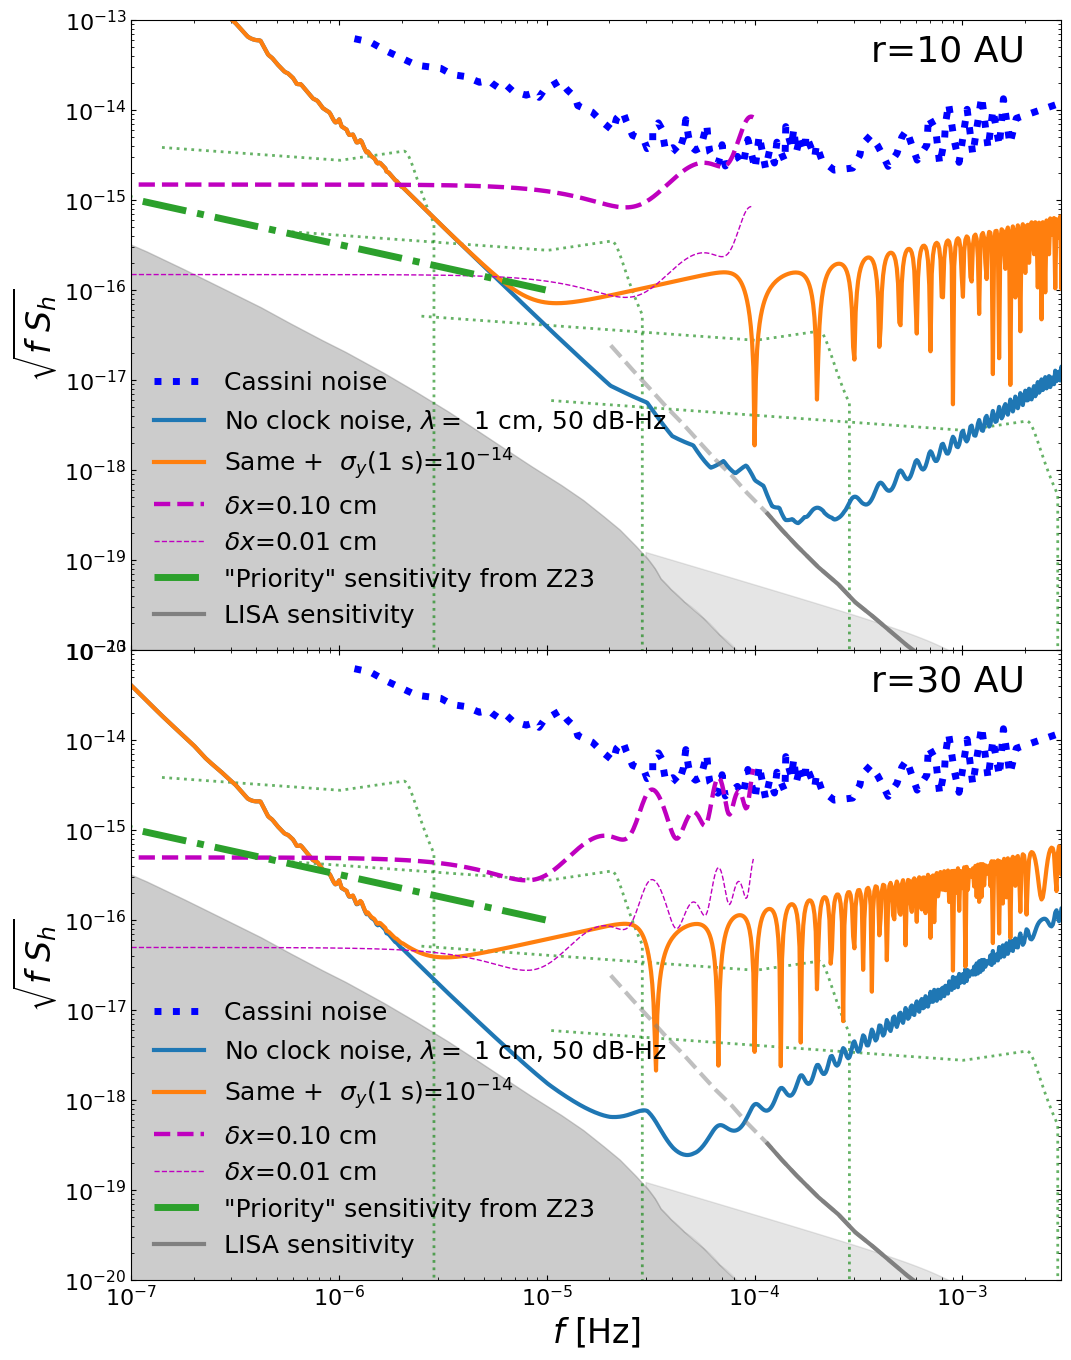

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables are already defined:
# - baseline_length_arr_AU: array of baseline lengths in AU
# - num_baselines: number of baselines (len(baseline_length_arr_AU))
# - freq_arr: array of frequencies
# - Romega_values_arr: array of transfer functions for each baseline
# - Romega_values_singlearm_arr: single-arm transfer functions
# - acc_solar_irradiance_msm2Hzmp5_arr
# - acceleration_drag_msm2Hzmp5_arr
# - acc_dust_msm2Hzmp5_arr (if used)
# - acc_bfield_msm2Hzmp5_arr (if used)


# Define constants and settings
FOR_NIAC = False
ontheskyreduction = 3 #fraction by wich sensitivity is reduced to the POWER owing to fact that continuous observations would be hard
geometric_suppression_doppler = 1  #1= no geometric supperssion of accelerations

# Create subplots with shared x-axis
fig, axes = plt.subplots(nrows=num_baselines, ncols=1, figsize=(12, 7 * num_baselines), sharex=True)
plt.subplots_adjust(hspace=0, top=0.95, bottom=0.05)
plt.rc('font', size=18)

#minimum frequency and y value (strain)
fminplot = 1e-7
yminplot = 3e-19

# Loop over each baseline length
for idx in range(num_baselines):
    baseline_length_AU = baseline_length_arr_AU[idx]
    ax = axes[idx] if num_baselines > 1 else axes

    # Extract the transfer functions
    Romega_values = Romega_values_arr[idx, :]
    Romega_values_singlearm = Romega_values_singlearm_arr[idx, :]

    # Extract the acceleration arrays for this baseline
    acc_solar_irradiance_msm2Hzmp5 = acc_solar_irradiance_msm2Hzmp5_arr[idx, :]
    acceleration_drag_msm2Hzmp5 = acceleration_drag_msm2Hzmp5_arr[idx, :]

    # Calculate the noise sources for the current baseline
    noise_60dBHz = strainNoiseShotorThermal(60, lambda0, baseline_length_AU, A=radio_enhancement_beamnoise)
    noise_40dBHz = strainNoiseShotorThermal(40, lambda0, baseline_length_AU, A=radio_enhancement_beamnoise)
    noise_40dBHz_laser = strainNoiseShotorThermal(40, 10000 * 1e-8, baseline_length_AU)

    if baseline_length_AU == 10:
        noise_radiometer = noise_60dBHz
    else:
        noise_radiometer  = noise_40dBHz

    # Plot Cassini constraint (A bit of work to convert from values in Armstrong TDI review since they report different quantity)
    plot_cassini_constraint = True
    if plot_cassini_constraint:
        tau = 40 * secinday #Cassini observed for 40 days  
        file_path = 'OSS_data_files/cassini_armstrong_sensitivity.dat' #data snatched from https://iopscience.iop.org/article/10.1086/308110
        cassini_data = np.genfromtxt(file_path, delimiter=',')
        cassini_nu = 10 ** cassini_data[:, 0]
        cassini_strain = 10 ** cassini_data[:, 1] * np.sqrt(tau * cassini_nu)
        ax.plot(cassini_nu, cassini_strain, lw=5, linestyle=':', color='b', label="Cassini noise")

    # Include signals
    include_signals = True
    if include_signals:
        freq_arr_reduced = freq_arr[freq_arr > 3e-5]
        characteristic_strain_MBHs_newrange = np.interp(freq_arr_reduced, nuMBHs, characteristic_strain_MBHs)
        characteristic_strain_MBHs_newrange[freq_arr_reduced < nuMBHs[0]] = 0
        characteristic_strain_MBHs_newrange[freq_arr_reduced > nuMBHs[-1]] = 0

        ax.fill_between(freq_arr_reduced, characteristic_strain_MBHs_newrange,
                        y2=freq_arr_reduced ** 0.5 * hnubinariesCornish(freq_arr_reduced),
                        color='gray', alpha=0.2)
        ax.fill_between(nuMBHs, np.zeros_like(characteristic_strain_MBHs), y2=characteristic_strain_MBHs,
                        color='gray', alpha=0.4)

        for massBH in [1e6, 1e7, 1e8, 1e9]:
            strainMBH = np.array([characteristicStrainMBH(nuGW, massBH, massBH) for nuGW in freq_arr])
            yearsbefore = 5
            minf = frequencyMB(massBH, massBH, yearsbefore)
            ax.loglog(freq_arr[freq_arr > minf], np.sqrt(1 / ontheskyreduction) * strainMBH[freq_arr > minf],
                      ':g', lw=2, alpha=0.6)

    # Calculate acceleration noise strains
    irradiance = accelerationNoiseStrain(freq_arr, acc_solar_irradiance_msm2Hzmp5,
                                         baseline_length_AU) * geometric_suppression_doppler
    drag = accelerationNoiseStrain(freq_arr, acceleration_drag_msm2Hzmp5,
                                   baseline_length_AU) * geometric_suppression_doppler

    # Total noise for 50 dB-Hz
    total_doppler = np.sqrt((noise_radiometer ** 2 + irradiance ** 2 + drag ** 2) /
                                Romega_values_singlearm / 2)  # Divided by 2 since single station noise and single arm radiometer noise 
                                                              # are relevant for doppler tracking
    ax.loglog(freq_arr, freq_arr ** 0.5 * total_doppler, lw=3,
              label='No clock noise, $\lambda =$ {:.0f} cm, 50 dB-Hz'.format(lambda0))

    # Define function for clock noise power
    def clocknoise_power(allan_deviation, nuGW, baseline_length_AU, nu_flicker=0):
        taubaseline = baseline_length_AU * AU_in_cm / lightspeed
        x = 2 * np.pi * nuGW * taubaseline
        return 2 * allan_deviation ** 2 * (1 - np.cos(2 * x)) / x ** 2 * (1 + nu_flicker / nuGW)

    # Plot clock noise contributions
    for allan_deviation in [1e-14]:
        total_clock = np.sqrt((noise_radiometer ** 2 + irradiance ** 2 + drag ** 2 +
                               clocknoise_power(allan_deviation, freq_arr, baseline_length_AU)) /
                              Romega_values_singlearm / 2)
        exponent = int(np.floor(np.log10(allan_deviation)))
        label = r'Same +  $\sigma_y$(1 s)=' + r'$10^{{{}}}$'.format(exponent)
        ax.loglog(freq_arr, freq_arr ** 0.5 * total_clock, lw=3, label=label)

    # Plot troposphere error
    plot_troposphere_error = True
    if plot_troposphere_error:
        for timing_error in [0.1, 0.01]:  # cm
            fmax = 1e-4
            nu_star = lightspeed / (4 * np.pi * baseline_length_AU * AU_in_cm)
            power = (timing_error / (baseline_length_AU * AU_in_cm)) / np.sqrt(freq_arr) * \
                    (1 + np.cos(freq_arr / nu_star) ** 2) / Romega_values ** 0.5
            ax.plot(freq_arr[freq_arr < fmax], np.sqrt(freq_arr[freq_arr < fmax]) * power[freq_arr < fmax],
                    lw=np.sqrt(100 * timing_error), linestyle='--', color='m',
                    label=r"$\delta x$" + "={:.2f} cm".format(timing_error))

    # Plot sensitivity from Z23 (assuming data is provided)
    def log10_linear_interpolation(twopoints, x_new):
        log10_twopoints = np.log10(twopoints)
        x1, y1 = log10_twopoints[0]
        x2, y2 = log10_twopoints[1]
        slope = (y2 - y1) / (x2 - x1)
        log10_y_new = slope * (np.log10(x_new) - x1) + y1
        y_new = 10 ** log10_y_new
        return y_new

    # Example data for "baseline" and "priority" sensitivity from Z23
    baseline_sensitivity = np.array([[3e-8, 1e-14], [3e-5, 3e-16]]) #this is a rough fit to their plot
    priority_sensitivity = baseline_sensitivity / 3   #their priority sensitivity is baseline divided by 3

    ax.loglog(freq_arr[freq_arr < 1e-5], log10_linear_interpolation(priority_sensitivity, freq_arr[freq_arr < 1e-5]),
              lw=acc_width + 2, ls='-.', alpha=alpha_dB, label=f'"Priority" sensitivity from Z23')

    # Plot LISA sensitivity
    lisa = np.genfromtxt('OSS_data_files/LISA_sensitivity_log.dat')
    lisa[:, 0] = 10 ** lisa[:, 0]
    lisa[:, 1] = 10 ** lisa[:, 1]
    ax.loglog(lisa[:, 0], lisa[:, 0] ** 0.5 * lisa[:, 1], '--', lw=3, color='gray', alpha=0.5)
    ax.loglog(lisa[lisa[:, 0] > 1e-4, 0], lisa[lisa[:, 0] > 1e-4, 0] ** 0.5 * lisa[lisa[:, 0] > 1e-4, 1],
              '-', lw=3, color='gray', alpha=1, label='LISA sensitivity')

    # Set labels and legend
    if idx == num_baselines - 1:
        ax.set_xlabel(r'$f$ [Hz]', fontsize=24)

    ax.set_ylabel(r'$\sqrt{f ~ S_{h}}$', fontsize=24)
    ax.legend(fontsize=18, loc='lower left', ncol=1, frameon=False)

    ax.tick_params(axis='both', which='major', labelsize=16)

    # Set x and y limits
    ax.set_xlim([1e-7, 0.003])
    ax.set_ylim([1e-20, 1e-13])

    # Add text with baseline length
    ax.text(0.002, .7e-13, r'r={} AU'.format(baseline_length_AU),
            fontsize=26, ha='right', va='top')

    # Adjust tick parameters for aesthetics
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', top=True, direction='in')
    ax.tick_params(axis='y', right=True, direction='in')
    ax.tick_params(axis='both', which='minor', direction='in')
    ax.tick_params(axis='x', which='minor', top=True)
    ax.tick_params(axis='y', which='minor', right=True)
    #ax.set_title("change dBHz")
# Adjust layout

# Optionally, save the figure
# plt.savefig("figures/strainsensitivity_A{}m{}_dopplertracking.pdf".format(area_spacecraft_irradiance_msq, mass_spacecraft_kg), format='pdf')

plt.show()


## plot 5 v2

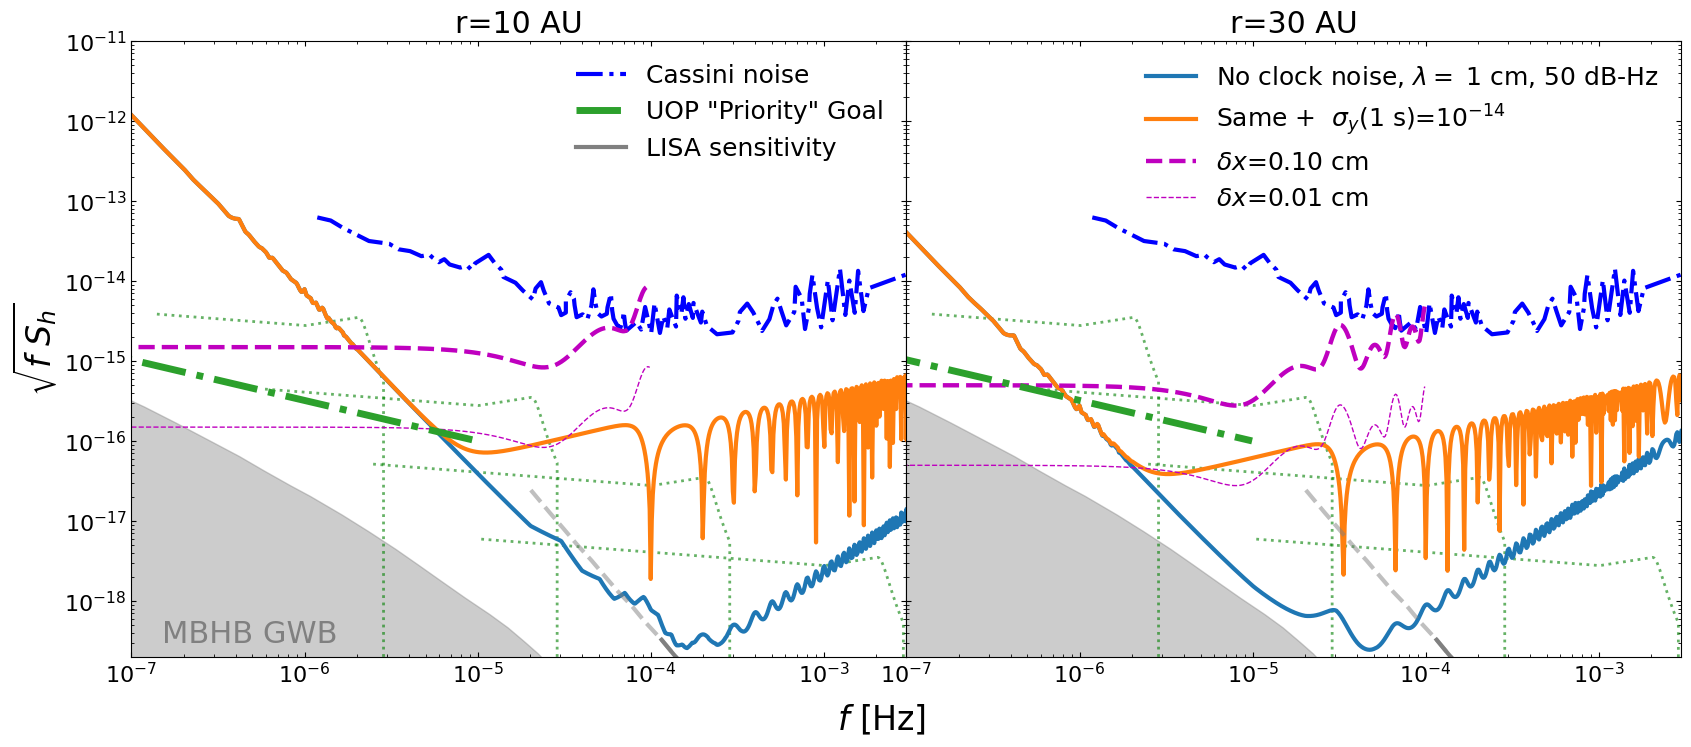

In [22]:
# Assuming the following variables are already defined:
# - baseline_length_arr_AU: array of baseline lengths in AU
# - num_baselines: number of baselines (len(baseline_length_arr_AU))
# - freq_arr: array of frequencies
# - Romega_values_arr: array of transfer functions for each baseline
# - Romega_values_singlearm_arr: single-arm transfer functions
# - acc_solar_irradiance_msm2Hzmp5_arr
# - acceleration_drag_msm2Hzmp5_arr
# - acc_dust_msm2Hzmp5_arr (if used)
# - acc_bfield_msm2Hzmp5_arr (if used)


# Define constants and settings
FOR_NIAC = False
ontheskyreduction = 3 #fraction by wich sensitivity is reduced to the POWER owing to fact that continuous observations would be hard
geometric_suppression_doppler = 1  #1= no geometric supperssion of accelerations

# Create subplots with shared x-axis
fig, axes = plt.subplots(nrows=1, ncols=num_baselines, figsize=(10 * num_baselines, 4 * num_baselines), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0)
plt.rc('font', size=18)

#minimum frequency and y value (strain)
fminplot = 1e-7
yminplot = 2e-19

# Loop over each baseline length
for idx in range(num_baselines):
    baseline_length_AU = baseline_length_arr_AU[idx]
    ax = axes[idx] if num_baselines > 1 else axes

    # Extract the transfer functions
    Romega_values = Romega_values_arr[idx, :]
    Romega_values_singlearm = Romega_values_singlearm_arr[idx, :]

    # Extract the acceleration arrays for this baseline
    acc_solar_irradiance_msm2Hzmp5 = acc_solar_irradiance_msm2Hzmp5_arr[idx, :]
    acceleration_drag_msm2Hzmp5 = acceleration_drag_msm2Hzmp5_arr[idx, :]

    # Calculate the noise sources for the current baseline
    noise_60dBHz = strainNoiseShotorThermal(60, lambda0, baseline_length_AU, A=radio_enhancement_beamnoise)
    noise_40dBHz = strainNoiseShotorThermal(40, lambda0, baseline_length_AU, A=radio_enhancement_beamnoise)
    noise_40dBHz_laser = strainNoiseShotorThermal(40, 10000 * 1e-8, baseline_length_AU)

    if baseline_length_AU == 10:
        noise_radiometer = noise_60dBHz
    else:
        noise_radiometer  = noise_40dBHz

    # Plot Cassini constraint (A bit of work to convert from values in Armstrong TDI review since they report different quantity)
    plot_cassini_constraint = True
    if plot_cassini_constraint:
        tau = 40 * secinday #Cassini observed for 40 days  
        file_path = 'OSS_data_files/cassini_armstrong_sensitivity.dat' #data snatched from https://iopscience.iop.org/article/10.1086/308110
        cassini_data = np.genfromtxt(file_path, delimiter=',')
        cassini_nu = 10 ** cassini_data[:, 0]
        cassini_strain = 10 ** cassini_data[:, 1] * np.sqrt(tau * cassini_nu)
        if idx == 0:
            ax.plot(cassini_nu, cassini_strain, lw=3, linestyle='-.', color='b', label="Cassini noise")
        else:
            ax.plot(cassini_nu, cassini_strain, lw=3, linestyle='-.', color='b')

    # Include signals
    include_signals = True
    if include_signals:
        freq_arr_reduced = freq_arr[freq_arr > 3e-5]
        characteristic_strain_MBHs_newrange = np.interp(freq_arr_reduced, nuMBHs, characteristic_strain_MBHs)
        characteristic_strain_MBHs_newrange[freq_arr_reduced < nuMBHs[0]] = 0
        characteristic_strain_MBHs_newrange[freq_arr_reduced > nuMBHs[-1]] = 0

        ax.fill_between(freq_arr_reduced, characteristic_strain_MBHs_newrange,
                        y2=freq_arr_reduced ** 0.5 * hnubinariesCornish(freq_arr_reduced),
                        color='gray', alpha=0.2)
        ax.fill_between(nuMBHs, np.zeros_like(characteristic_strain_MBHs), y2=characteristic_strain_MBHs,
                        color='gray', alpha=0.4)


        if idx == 0:
            ax.text(fminplot * 1.5, yminplot * 1.5, "MBHB GWB", color='gray', alpha=1, fontsize=22, ha='left', rotation=0)
        

        for massBH in [1e6, 1e7, 1e8, 1e9]:
            strainMBH = np.array([characteristicStrainMBH(nuGW, massBH, massBH) for nuGW in freq_arr])
            yearsbefore = 5
            minf = frequencyMB(massBH, massBH, yearsbefore)
            ax.loglog(freq_arr[freq_arr > minf], np.sqrt(1 / ontheskyreduction) * strainMBH[freq_arr > minf],
                      ':g', lw=2, alpha=0.6)

    # Calculate acceleration noise strains
    irradiance = accelerationNoiseStrain(freq_arr, acc_solar_irradiance_msm2Hzmp5,
                                         baseline_length_AU) * geometric_suppression_doppler
    drag = accelerationNoiseStrain(freq_arr, acceleration_drag_msm2Hzmp5,
                                   baseline_length_AU) * geometric_suppression_doppler

    # Total noise for 50 dB-Hz
    total_doppler = np.sqrt((noise_radiometer ** 2 + irradiance ** 2 + drag ** 2) /
                                Romega_values_singlearm / 2)  # Divided by 2 since single station noise and single arm radiometer noise 
                                                              # are relevant for doppler tracking
    if idx == num_baselines - 1:
        ax.loglog(freq_arr, freq_arr ** 0.5 * total_doppler, lw=3,
                  label='No clock noise, $\lambda =$ {:.0f} cm, 50 dB-Hz'.format(lambda0))
    else:
        ax.loglog(freq_arr, freq_arr ** 0.5 * total_doppler, lw=3,)

    # Define function for clock noise power
    def clocknoise_power(allan_deviation, nuGW, baseline_length_AU, nu_flicker=0):
        taubaseline = baseline_length_AU * AU_in_cm / lightspeed
        x = 2 * np.pi * nuGW * taubaseline
        return 2 * allan_deviation ** 2 * (1 - np.cos(2 * x)) / x ** 2 * (1 + nu_flicker / nuGW)

    # Plot clock noise contributions
    for allan_deviation in [1e-14]:
        total_clock = np.sqrt((noise_radiometer ** 2 + irradiance ** 2 + drag ** 2 +
                               clocknoise_power(allan_deviation, freq_arr, baseline_length_AU)) /
                              Romega_values_singlearm / 2)
        exponent = int(np.floor(np.log10(allan_deviation)))
        label = r'Same +  $\sigma_y$(1 s)=' + r'$10^{{{}}}$'.format(exponent)
        if idx == num_baselines - 1:
            ax.loglog(freq_arr, freq_arr ** 0.5 * total_clock, lw=3, label=label)
        else:
            ax.loglog(freq_arr, freq_arr ** 0.5 * total_clock, lw=3)

    # Plot troposphere error
    plot_troposphere_error = True
    if plot_troposphere_error:
        for timing_error in [0.1, 0.01]:  # cm
            fmax = 1e-4
            nu_star = lightspeed / (4 * np.pi * baseline_length_AU * AU_in_cm)
            power = (timing_error / (baseline_length_AU * AU_in_cm)) / np.sqrt(freq_arr) * \
                    (1 + np.cos(freq_arr / nu_star) ** 2) / Romega_values ** 0.5
            if idx == num_baselines - 1:
                ax.plot(freq_arr[freq_arr < fmax], np.sqrt(freq_arr[freq_arr < fmax]) * power[freq_arr < fmax],
                        lw=np.sqrt(100 * timing_error), linestyle='--', color='m',
                        label=r"$\delta x$" + "={:.2f} cm".format(timing_error))
            else:
                ax.plot(freq_arr[freq_arr < fmax], np.sqrt(freq_arr[freq_arr < fmax]) * power[freq_arr < fmax],
                        lw=np.sqrt(100 * timing_error), linestyle='--', color='m')

    # Plot sensitivity from Z23 (assuming data is provided)
    def log10_linear_interpolation(twopoints, x_new):
        log10_twopoints = np.log10(twopoints)
        x1, y1 = log10_twopoints[0]
        x2, y2 = log10_twopoints[1]
        slope = (y2 - y1) / (x2 - x1)
        log10_y_new = slope * (np.log10(x_new) - x1) + y1
        y_new = 10 ** log10_y_new
        return y_new

    # Example data for "baseline" and "priority" sensitivity from Z23
    baseline_sensitivity = np.array([[3e-8, 1e-14], [3e-5, 3e-16]]) #this is a rough fit to their plot
    priority_sensitivity = baseline_sensitivity / 3   #their priority sensitivity is baseline divided by 3

    if idx == 0:
        ax.loglog(freq_arr[freq_arr < 1e-5], log10_linear_interpolation(priority_sensitivity, freq_arr[freq_arr < 1e-5]),
                  lw=acc_width + 2, ls='-.', alpha=alpha_dB, label=f'UOP "Priority" Goal')
    else:
        ax.loglog(freq_arr[freq_arr < 1e-5], log10_linear_interpolation(priority_sensitivity, freq_arr[freq_arr < 1e-5]),
                  lw=acc_width + 2, ls='-.', alpha=alpha_dB)

    # Plot LISA sensitivity
    lisa = np.genfromtxt('OSS_data_files/LISA_sensitivity_log.dat')
    lisa[:, 0] = 10 ** lisa[:, 0]
    lisa[:, 1] = 10 ** lisa[:, 1]
    ax.loglog(lisa[:, 0], lisa[:, 0] ** 0.5 * lisa[:, 1], '--', lw=3, color='gray', alpha=0.5)
    if idx == 0:
        ax.loglog(lisa[lisa[:, 0] > 1e-4, 0], lisa[lisa[:, 0] > 1e-4, 0] ** 0.5 * lisa[lisa[:, 0] > 1e-4, 1],
                  '-', lw=3, color='gray', alpha=1, label='LISA sensitivity')
    else:
        ax.loglog(lisa[lisa[:, 0] > 1e-4, 0], lisa[lisa[:, 0] > 1e-4, 0] ** 0.5 * lisa[lisa[:, 0] > 1e-4, 1],
                  '-', lw=3, color='gray', alpha=1)

    # Set labels and legend
    if idx == 0:
        ax.set_ylabel(r'$\sqrt{f ~ S_{h}}$', fontsize=24)
    ax.legend(fontsize=18, loc='upper right', ncol=1, frameon=False)

    ax.tick_params(axis='both', which='major', labelsize=16)

    # Set x and y limits
    ax.set_xlim([1e-7, 0.003])
    ax.set_ylim([yminplot, 1e-11])

    # Add text with baseline length
    ax.set_title(r'r={} AU'.format(baseline_length_AU))

    # Adjust tick parameters for aesthetics
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', top=True, direction='in')
    ax.tick_params(axis='y', right=True, direction='in')
    ax.tick_params(axis='both', which='minor', direction='in')
    ax.tick_params(axis='x', which='minor', top=True)
    ax.tick_params(axis='y', which='minor', right=True)

fig.supxlabel(r'$f$ [Hz]', fontsize=24)


# Adjust layout

# Optionally, save the figure
# plt.savefig("figures/strainsensitivity_A{}m{}_dopplertracking.pdf".format(area_spacecraft_irradiance_msq, mass_spacecraft_kg), format='pdf')

# plt.savefig("/Users/cdmcgrat/Desktop/matt_updated_figs/fig5.pdf", bbox_inches='tight', format='pdf')

plt.show()
